**Reference**: <https://daviddalpiaz.github.io/appliedstats/model-diagnostics.html#outliers>

In [1]:
library(tidyverse)
library(broom)

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



# 1. Model Assumptions

Often, the assumptions of linear regression, are stated as **LINE**:

- **L**inearity: the response can be written as a linear combination of the predictors. (With noise about this true linear relationship.)
- **I**ndependence: the errors are independent.
- **N**ormality: the distribution of the errors should follow a normal distribution.
- **E**qual Variance: the error variance is the same at any set of predictor values.

## Why model diagnostic?

If these assumptions are met, great! We can perform inference, and it is valid. If these assumptions are not met, we can still “perform” a  
t
 -test using R, but the results are not valid. The distributions of the parameter estimates will not be what we expect. Hypothesis tests will then accept or reject incorrectly. Essentially, garbage in, garbage out.

# 2. Checking Assumptions

Model 1: $Y = 3 + 5x + \epsilon, \epsilon \sim N(0,1)$  
Model 2: $Y = 3 + 5x + \epsilon, \epsilon \sim N(0, x^2)$  
Model 3: $Y = 3 + 5x^2 + \epsilon, \epsilon \sim N(0, 25)$

In [2]:
sim_1 = function(sample_size = 500) {
  x = runif(n = sample_size) * 5
  y = 3 + 5 * x + rnorm(n = sample_size, mean = 0, sd = 1)
  data.frame(x, y)
}

sim_2 = function(sample_size = 500) {
  x = runif(n = sample_size) * 5
  y = 3 + 5 * x + rnorm(n = sample_size, mean = 0, sd = x)
  data.frame(x, y)
}

sim_3 = function(sample_size = 500) {
  x = runif(n = sample_size) * 5
  y = 3 + 5 * x ^ 2 + rnorm(n = sample_size, mean = 0, sd = 5)
  data.frame(x, y)
}

## 2.1 Fitted vs Residuals plot

Checking **linear** and **constant variance** assumptions
- **linear**: At each predicted value, the mean of residuals should be roughly 0
- **constant variance**: The variance of residuals for each predicted value should be roughly the same

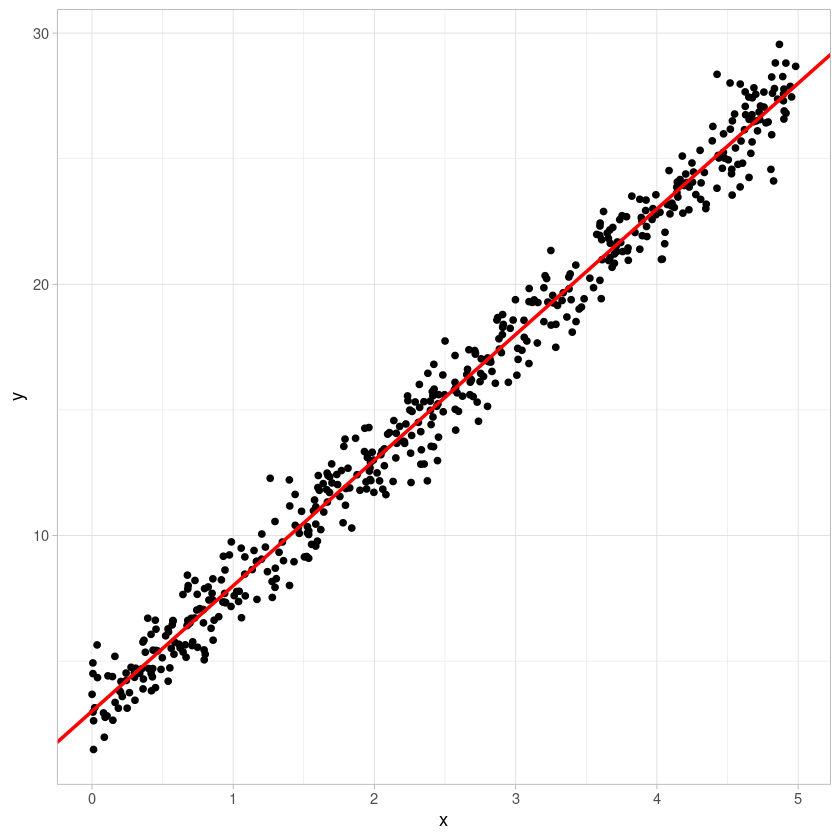

In [3]:
set.seed(42)
sim_data_1 <- sim_1()

sim_data_1 %>%
ggplot(aes(x, y)) + 
geom_point() + 
geom_abline(slope = 5, intercept = 3, color = "red", size = 1) + 
theme_light()

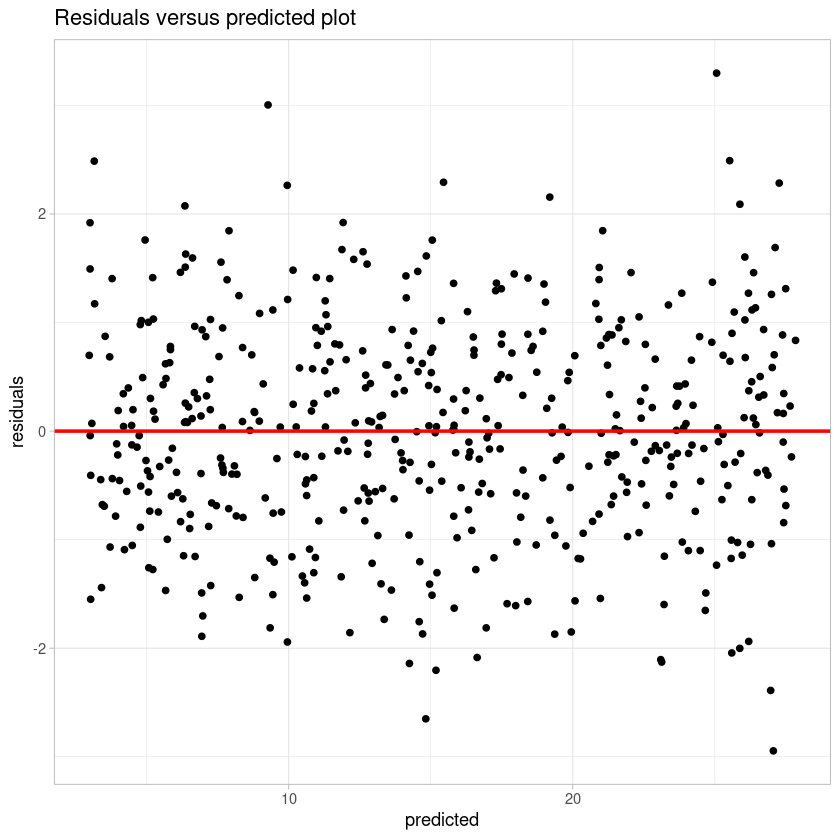

In [4]:
fit_1 <- lm(y ~ x, data = sim_data_1)
fit_1 %>% 
augment() %>%
ggplot(aes(fitted(fit_1), .resid)) +
geom_point() +
geom_hline(yintercept = 0, size = 1, color = "red") + 
labs(title = "Residuals versus predicted plot",
     x = "predicted",
     y = "residuals") + 
theme_light()

We should look for two things in this plot.

At any fitted value, the mean of the residuals should be roughly 0. If this is the case, the linearity assumption is valid. For this reason, we generally add a horizontal line at   y = 0 to emphasize this point.
At every fitted value, the spread of the residuals should be roughly the same. If this is the case, the constant variance assumption is valid.
Here we see this is the case for both.

To get a better idea of how a fitted versus residuals plot can be useful, we will simulate from models with violated assumptions.

Model 2 is an example of non-constant variance. In this case, the variance is larger for larger values of the predictor variable   x .

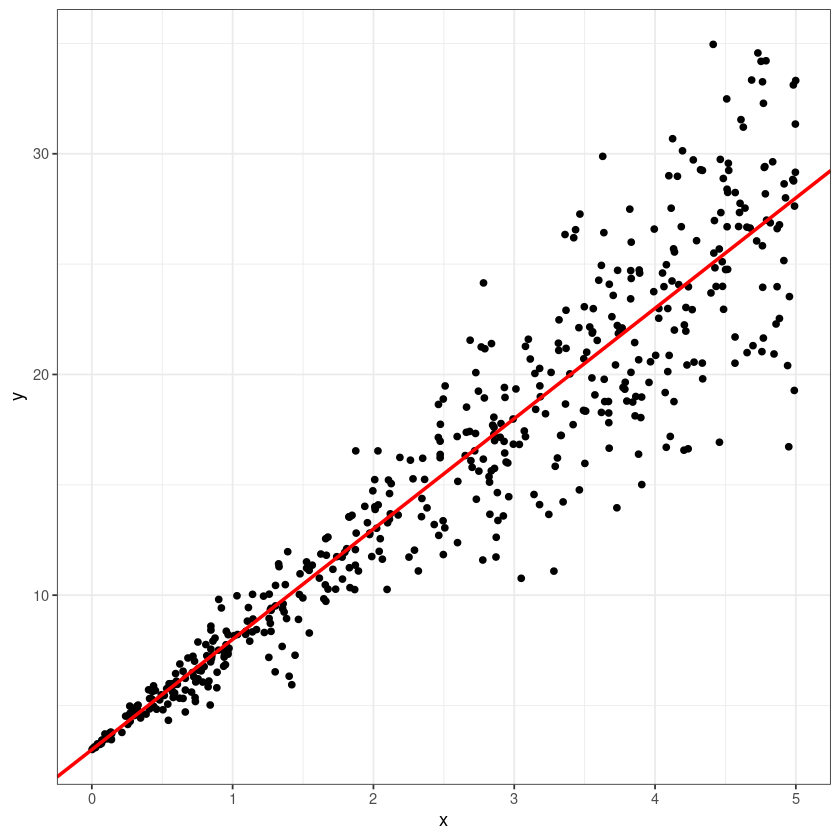

In [5]:
sim_data_2 <- sim_2()
sim_data_2 %>%
ggplot(aes(x, y)) + 
geom_point() + 
geom_abline(slope = 5, intercept = 3, size = 1, color = "red") +
theme_bw()

In [6]:
fit_2 <- lm(y ~ x, sim_data_2)

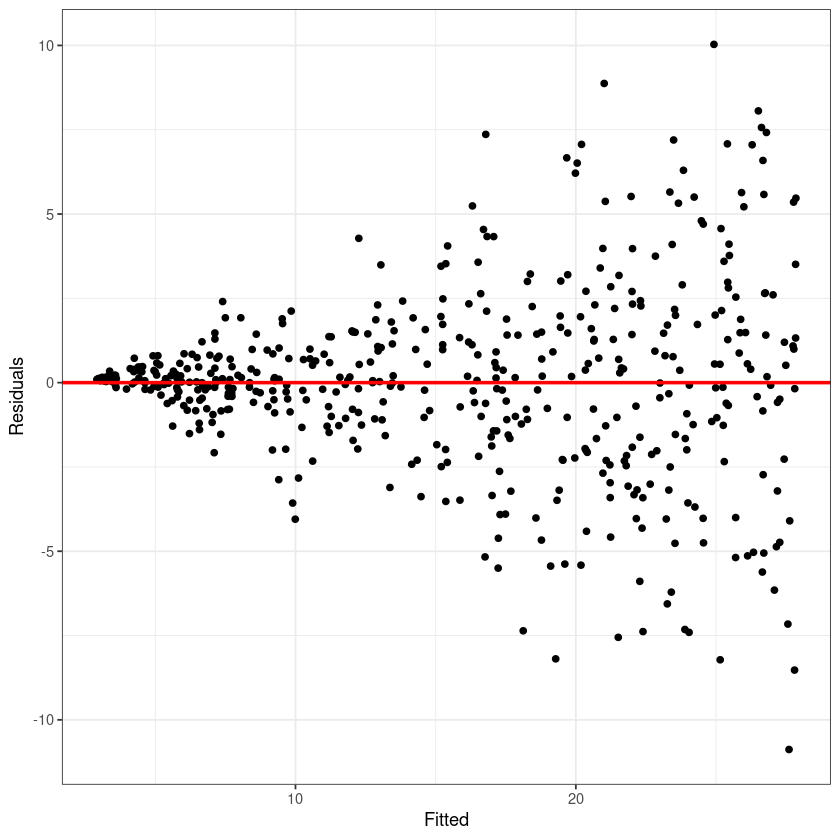

In [7]:
fit_2 %>%
augment() %>% 
ggplot(aes(fitted(fit_2), .resid)) + 
geom_point() + 
geom_hline(yintercept = 0, size = 1, color = "red") +
labs(x = "Fitted", y = "Residuals") +
theme_bw()

On the fitted versus residuals plot, we see two things very clearly. For any fitted value, the residuals seem roughly centered at 0. This is good! The linearity assumption is not violated. However, we also see very clearly, that for larger fitted values, the spread of the residuals is larger. This is bad! The constant variance assumption is violated here.

Now we will demonstrate a model which does not meet the linearity assumption. Model 3 is an example of a model where   Y is not a linear combination of the predictors. In this case the predictor is   x , but the model uses  $x^2$ . 

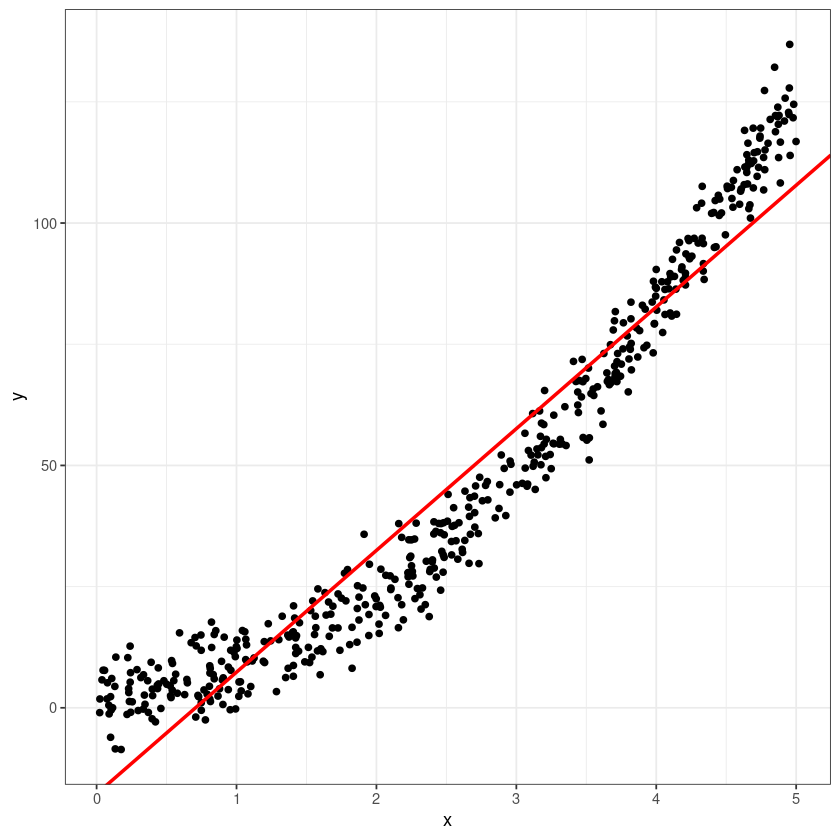

In [8]:
sim_data_3 <- sim_3()
fit_3 <- lm(y ~ x, data = sim_data_3)
sim_data_3 %>%
ggplot(aes(x, y)) + 
geom_point() + 
geom_abline(slope = coef(fit_3)[[2]], intercept = coef(fit_3)[[1]], size = 1, color = "red") +
theme_bw()

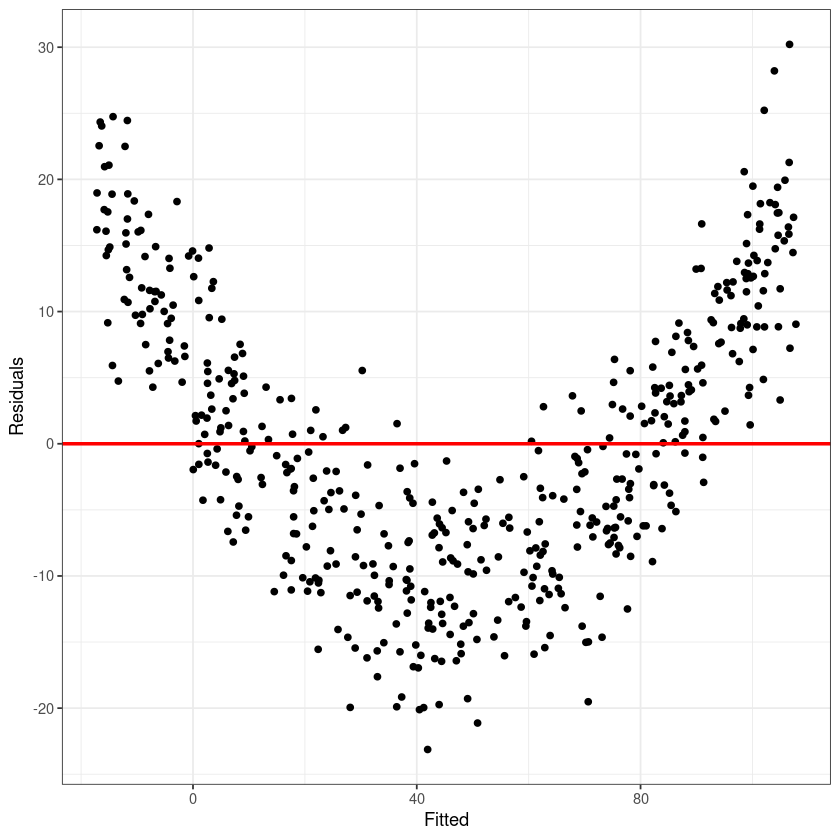

In [9]:
fit_3 %>%
augment() %>% 
ggplot(aes(fitted(fit_3), .resid)) + 
geom_point() + 
geom_hline(yintercept = 0, size = 1, color = "red") +
labs(x = "Fitted", y = "Residuals") +
theme_bw()

This time on the fitted versus residuals plot, for any fitted value, the spread of the residuals is about the same. However, they are not even close to centered at zero! At small and large fitted values the model is underestimating, while at medium fitted values, the model is overestimating. These are systematic errors, not random noise. So the constant variance assumption is met, but the linearity assumption is violated. The form of our model is simply wrong. We’re trying to fit a line to a curve!

## 2.2 Breusch-Pagan Test

Constant variance is often called homoscedasticity. Conversely, non-constant variance is called heteroscedasticity. We’ve seen how we can use a fitted versus residuals plot to look for these attributes.

While a fitted versus residuals plot can give us an idea about homoscedasticity, sometimes we would prefer a more formal test. There are many tests for constant variance, but here we will present one, the Breusch-Pagan Test. The exact details of the test will omitted here, but importantly the null and alternative can be considered to be:  

$H_0$: The errors have constant variance about the true model  
$H_1$:  Heteroscedasticity. The errors have non-constant variance about the true model.

> we will use **`lmtest::bptest`**

In [10]:
library(lmtest)

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




In [11]:
bptest(fit_1)


	studentized Breusch-Pagan test

data:  fit_1
BP = 1.0234, df = 1, p-value = 0.3117


p value > 0.05 so we fail to reject $H_0$, concludes that the variance is constant at 0.05 significant level

In [12]:
bptest(fit_2)


	studentized Breusch-Pagan test

data:  fit_2
BP = 97.384, df = 1, p-value < 2.2e-16


p value < 0.05 so we reject $H_0$, concludes that the variance is not constant at 0.05 significant level

In [13]:
bptest(fit_3)


	studentized Breusch-Pagan test

data:  fit_3
BP = 0.4899, df = 1, p-value = 0.484


p value > 0.05 so we reject $H_0$, concludes that the variance is constant at 0.05 significant level

## 2.3 Histogram

Checking for **normal** assumption

We have a number of tools for assessing the normality assumption. The most obvious would be to make a histogram of the residuals. If it appears roughly normal, then we’ll believe the errors could truly be normal.

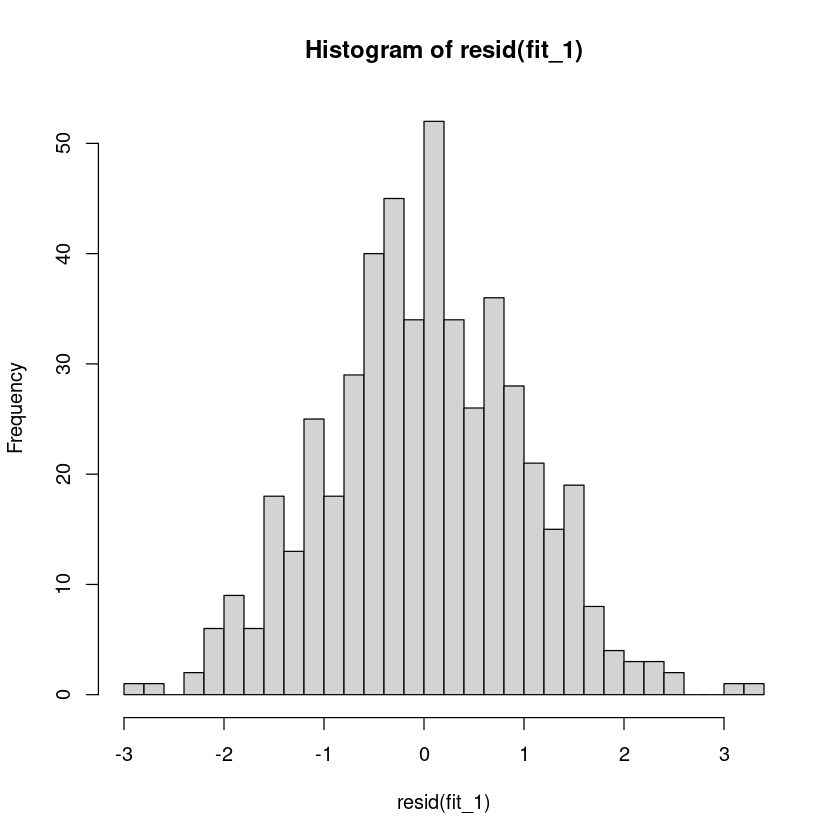

In [14]:
hist(resid(fit_1), breaks = 30)

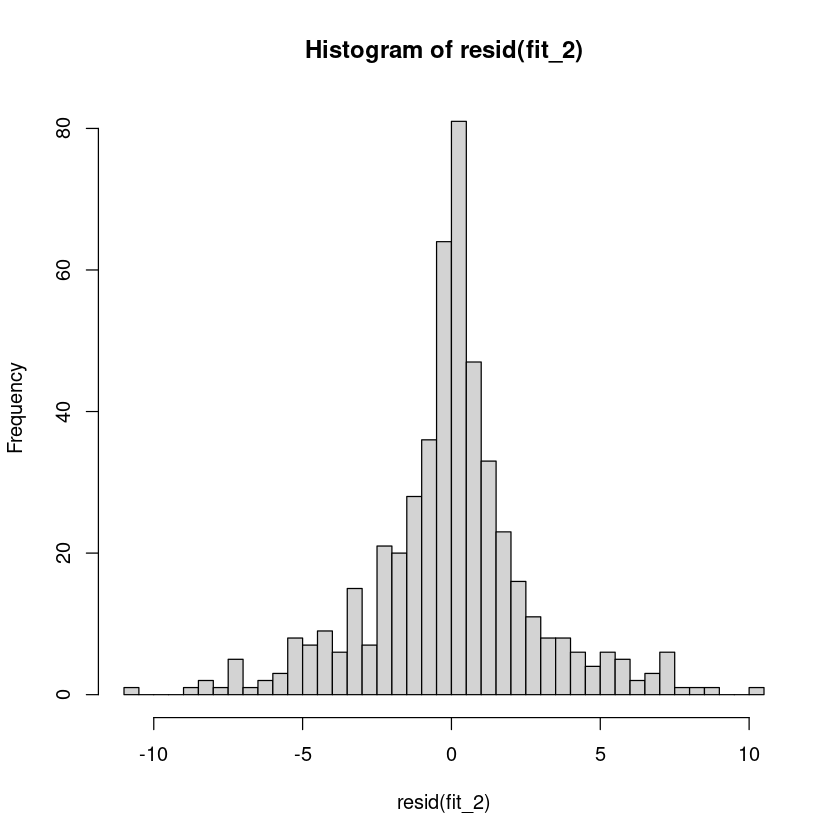

In [15]:
hist(resid(fit_2), breaks = 30)

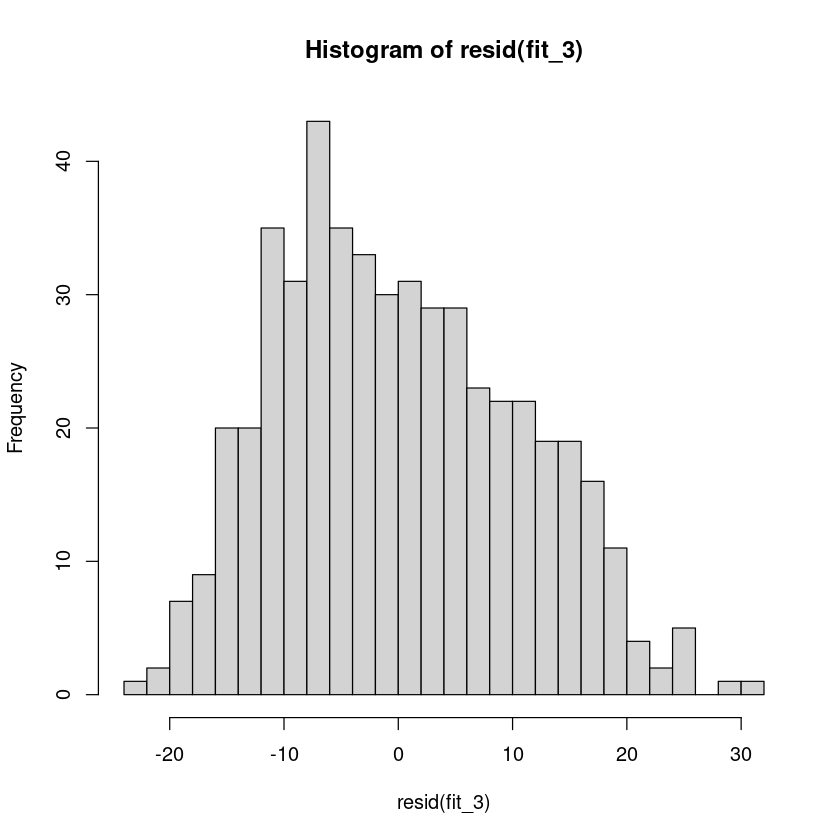

In [16]:
hist(resid(fit_3), breaks = 30)

Above are histograms for each of the three regression we have been considering. Notice that the first, for fit_1 appears very normal. The third, for fit_3, appears to be very non-normal. However fit_2 is not as clear. It does have a rough bell shape, however, it also has a very sharp peak. For this reason we will usually use more powerful tools such as Q-Q plots and the Shapiro-Wilk test for assessing the normality of errors.

## 2.4 Q-Q plot

Another visual method for assessing the normality of errors, which is more powerful than a histogram, is a normal quantile-quantile plot

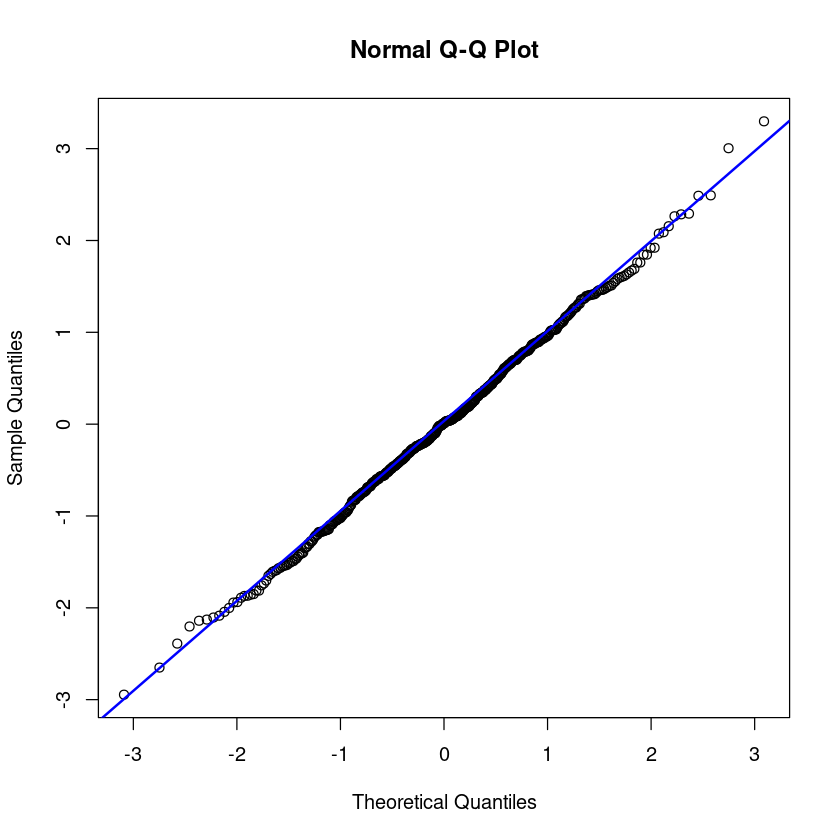

In [17]:
qqnorm(resid(fit_1))
qqline(resid(fit_1), lwd = 2, col = "blue")


For fit_1, we have a near perfect Q-Q plot. We would believe the errors follow a normal distribution.


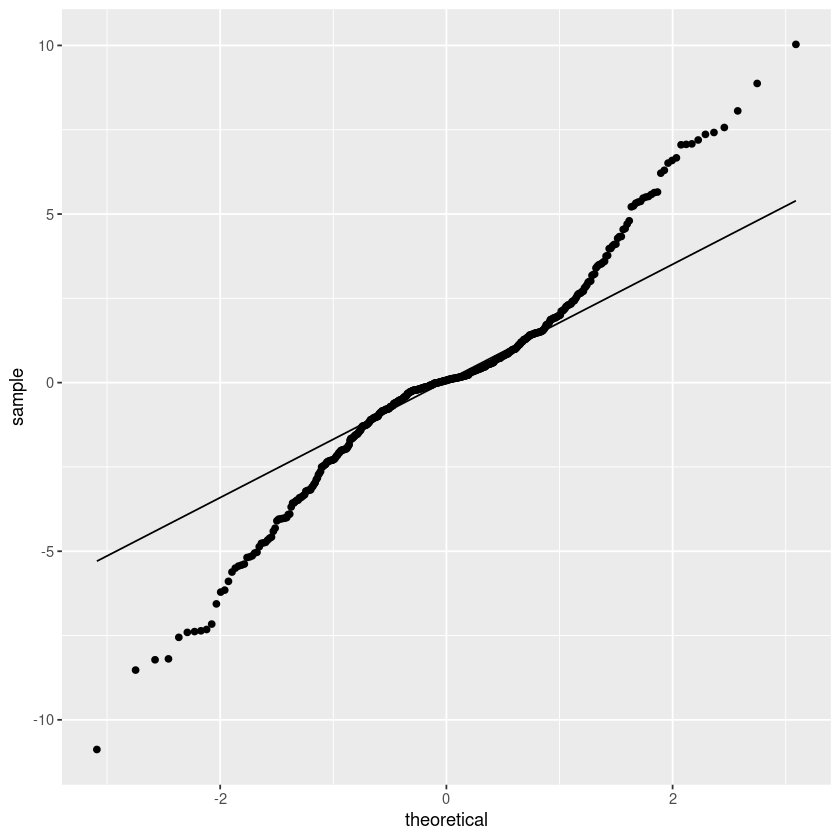

In [18]:
fit_2 %>%
augment() %>%
ggplot(aes(sample = .resid)) +
geom_qq() + 
geom_qq_line()

For fit_2, we have a suspect Q-Q plot. We would probably not believe the errors follow a normal distribution.

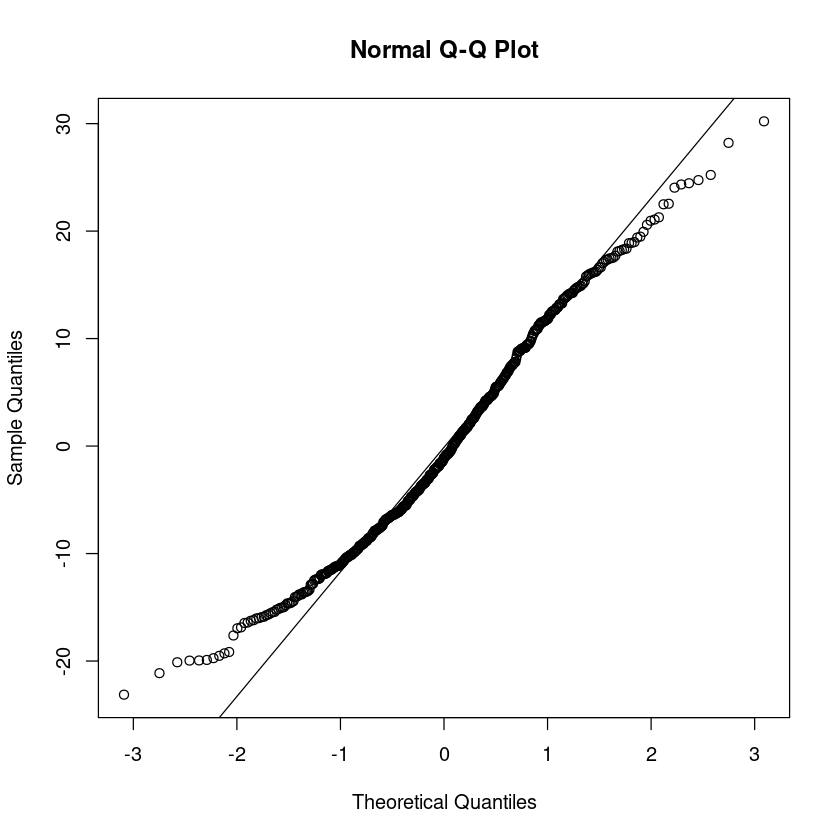

In [19]:
qqnorm(resid(fit_3))
qqline(resid(fit_3))

Lastly, for fit_3, we again have a suspect Q-Q plot. We would probably not believe the errors follow a normal distribution.

## 2.3 Shapiro-Wilk Test

$H_0$: The data were sampled from a normal distribution  
$H_1$: The data were not sampled from a normal distribution

In [20]:
shapiro.test(resid(fit_1))


	Shapiro-Wilk normality test

data:  resid(fit_1)
W = 0.99858, p-value = 0.9622


In [21]:
shapiro.test(resid(fit_2))


	Shapiro-Wilk normality test

data:  resid(fit_2)
W = 0.95728, p-value = 7.446e-11


In [22]:
shapiro.test(resid(fit_3))


	Shapiro-Wilk normality test

data:  resid(fit_3)
W = 0.98233, p-value = 9.157e-06


# 3. Unusual observations

In addition to checking the assumptions of regression, we also look for any “unusual observations” in the data. Often a small number of data points can have an extremely large influence on a regression, sometimes so much so that the regression assumptions are violated as a result of these points.

## 3.1 Leverage

**NOTE**: Read the book for the math behind leverage

Leverage: Have extreme value in the X axis. Large leverage orcurs when $x$ values are far from the mean $\bar{x}$. A data point with high leverage, is a data point that **could** have a large influence when fitting the model.

**NOTES**: Leverage only depends on the $x$ values (the value of predictors, it does not depends on the value of $y$, the response)

For Simple Linear Regression, we can calculate the leverage of the $i^{th}$ point: 
$$h_i = \frac{1}{n} + \frac{(x_i - \bar{x})^2}{S_{xx}}$$

What is a value of   $h_i$ that would be considered large? There is no exact answer to this question. A common heuristic would be to compare each leverage to two times the average leverage. A leverage larger than this is considered an observation to be aware of. That is, if 
$$h_i > 2 \bar{h}$$

> Use **`hatvalues(lmmodel)`** to find the leverage of each value in that model

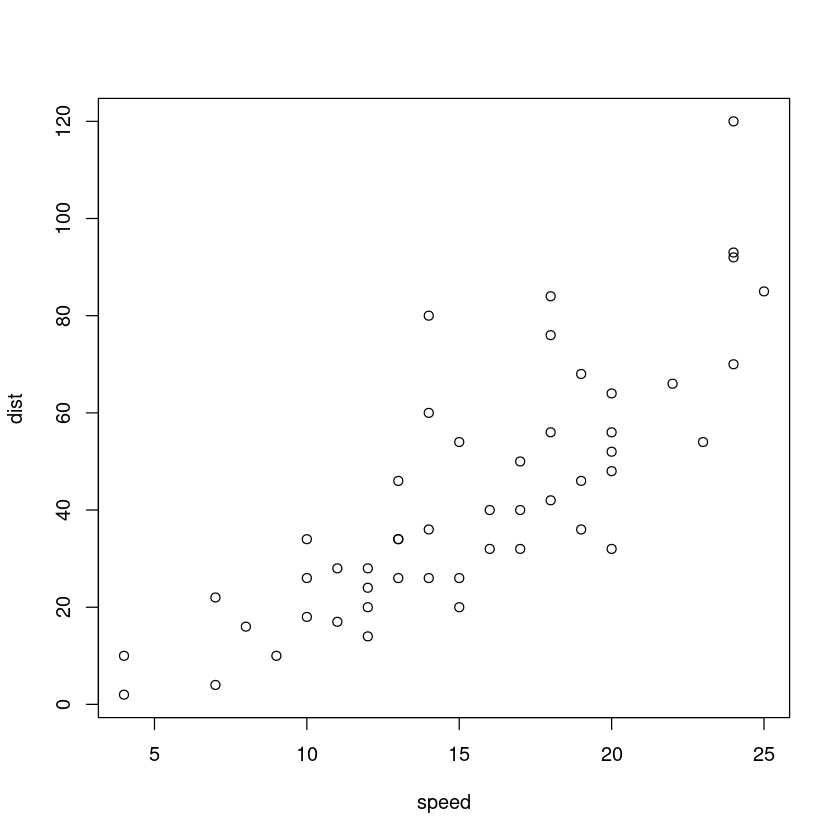

In [23]:
plot(dist ~ speed, data = cars)

In [24]:
mod <- lm(dist ~ speed, data = cars)

coef(mod)

(Intercept)       speed 
 -17.579095    3.932409

In [25]:
leverage <- hatvalues(mod)
leverage

1          2          3          4          5          6          7 
0.11486131 0.11486131 0.07150365 0.07150365 0.05997080 0.04989781 0.04128467 
         8          9         10         11         12         13         14 
0.04128467 0.04128467 0.03413139 0.03413139 0.02843796 0.02843796 0.02843796 
        15         16         17         18         19         20         21 
0.02843796 0.02420438 0.02420438 0.02420438 0.02420438 0.02143066 0.02143066 
        22         23         24         25         26         27         28 
0.02143066 0.02143066 0.02011679 0.02011679 0.02011679 0.02026277 0.02026277 
        29         30         31         32         33         34         35 
0.02186861 0.02186861 0.02186861 0.02493431 0.02493431 0.02493431 0.02493431 
        36         37         38         39         40         41         42 
0.02945985 0.02945985 0.02945985 0.03544526 0.03544526 0.03544526 0.03544526 
        43         44         45         46         47         48         49 
0.03544526 0.05179562 0.06216058 0.07398540 0.07398540 0.07398540 0.07398540 
        50 
0.08727007

In [26]:
# the index of the row having largest lerverage
idxmax <- which.max(leverage)
idxmin <- which.min(leverage)

# point with highest leverage
cars[idxmax, ]

,speed,dist
,<dbl>,<dbl>
1,4,2


In [27]:
# point with lowest leverage
cars[idxmin, ]

,speed,dist
,<dbl>,<dbl>
24,15,20


In [28]:
# change the y value of the point having largest leverage
cars_1 <- cars
cars_1[idxmax, 2] <- 50

mod1 <- lm(dist ~ speed, data = cars_1)
coef(mod1)
# coef change quite a lot compare to the original model
coef(mod)

(Intercept)       speed 
 -10.468088    3.532993

(Intercept)       speed 
 -17.579095    3.932409

In [29]:
# change the y value of the point having lowest leverage
cars_2 <- cars
cars_2[idxmin, 2] <- 50
mod2 <- lm(dist ~ speed, data = cars_2)

coef(mod2)
# coef does not change much compare the the original model
coef(mod)

(Intercept)       speed 
  -16.84420     3.92365

(Intercept)       speed 
 -17.579095    3.932409

In [30]:
# points that are considered having large leverage

leverage_points <- which(leverage > 2 * mean(leverage))
leverage_points

1  2 50 
 1  2 50

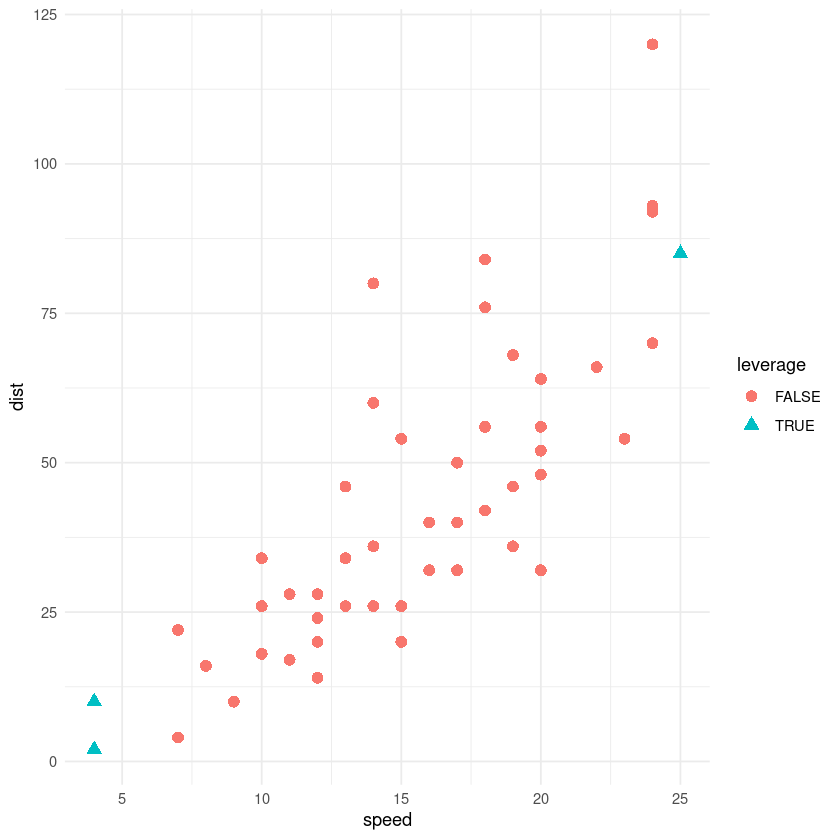

In [31]:
cars %>% 
mutate(leverage = row_number() %in% names(leverage_points)) %>% 
ggplot(aes(speed, dist, color = leverage, shape = leverage)) + 
geom_point(size = 3) + 
theme_minimal()

## 3.2 Outliers

Bascially, Outliers are points having large residuals. They are points that do not fit the model well. They **may** or **may not** have large effect on the model.

But what value should be considered as large residuals? If we standardized the residuals, the the **standardized residual** will follow N(0, 1) (**read the book for the math**). Large residuals will have **standardized residuals** larger than 2 or smaller than -2. (*This is just a heuristic, not an exact rule, chose the threshold that suits your problem*)

> Use **`rstandard()`** to obtain standard residual

In [32]:
rstandard(mod)

1           2           3           4           5           6 
 0.26604155  0.81893273 -0.40134618  0.81326629  0.14216236 -0.52115255 
          7           8           9          10          11          12 
-0.24869180  0.28256008  0.81381197 -0.57409795  0.15366341 -1.02971654 
         13          14          15          16          17          18 
-0.63392061 -0.37005667 -0.10619272 -0.49644946  0.03013240  0.03013240 
         19          20          21          22          23          24 
 0.82000518 -0.75422016 -0.09692637  1.48057874  2.79516632 -1.40612757 
         25          26          27          28          29          30 
-1.01201579  0.82717256 -0.87627072 -0.35074918 -1.13552237 -0.60956963 
         31          32          33          34          35          36 
 0.04787130 -0.73777117  0.18409193  1.50103921  2.02781813 -1.39503525 
         37          38          39          40          41          42 
-0.73502818  0.71698735 -1.92452335 -0.86524066 -0.60041999 -0.33559931 
         43          44          45          46          47          48 
 0.19404203 -0.19590672 -1.26671228 -0.45938126  1.02713306  1.09470190 
         49          50 
 2.91906038  0.29053451

`geom_smooth()` using formula 'y ~ x'



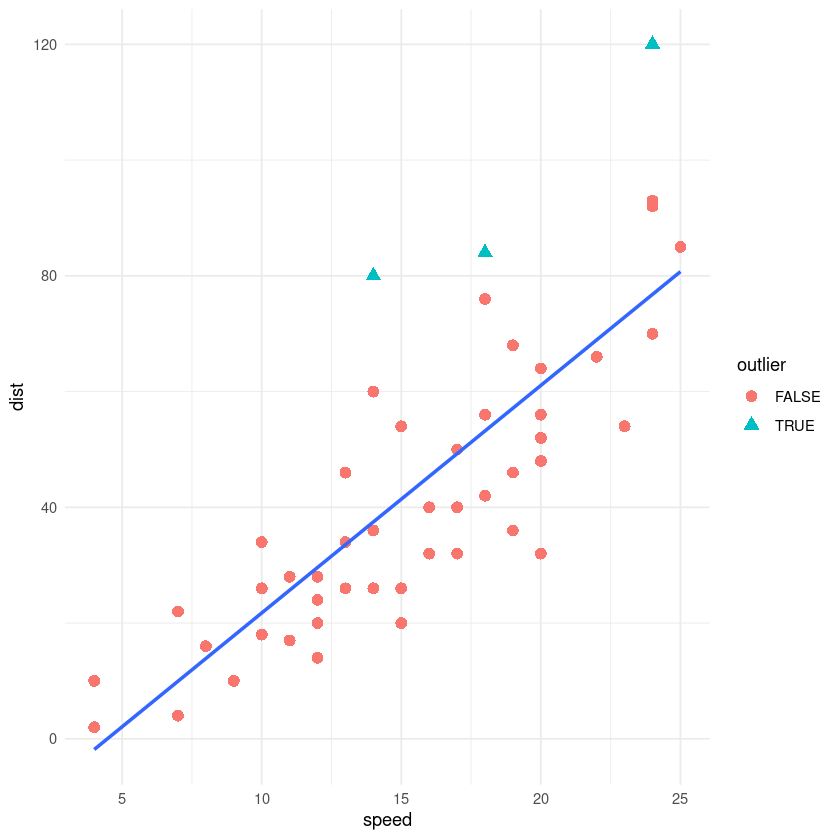

In [33]:
cars %>% 
mutate(outlier = abs(rstandard(mod)) > 2) %>% 
ggplot(aes(speed, dist)) + 
geom_point(aes(color = outlier, shape = outlier), size = 3) + 
geom_smooth(method = 'lm', se = F) + 
theme_minimal()

## 3.3 Influence

An influential point are points having both high **leverage** and high **residuals**

A common measure of influence is **Cook’s Distance**, which is a function of both *leverage* and *standardized residuals*

$$D_i = \frac{1}{p}r_i^2\frac{h_i}{1 - h_i}$$

A Cook’s Distance is often considered large if
$$D_i > \frac{4}{n}$$

and an observation with a large Cook’s Distance is called influential. This is again simply a heuristic, and not an exact rule.

> using **`cooks.distance(model)`** to calculate Cook's Distance

In [34]:
cooks.distance(mod)

1            2            3            4            5            6 
4.592312e-03 4.351399e-02 6.202350e-03 2.546734e-02 6.446705e-04 7.131993e-03 
           7            8            9           10           11           12 
1.331656e-03 1.719059e-03 1.425993e-02 5.823417e-03 4.172024e-04 1.551791e-02 
          13           14           15           16           17           18 
5.881222e-03 2.004169e-03 1.650393e-04 3.056717e-03 1.126088e-05 1.126088e-05 
          19           20           21           22           23           24 
8.339467e-03 6.228883e-03 1.028721e-04 2.400363e-02 8.555181e-02 2.029569e-02 
          25           26           27           28           29           30 
1.051305e-02 7.023387e-03 7.940281e-03 1.272192e-03 1.441403e-02 4.153753e-03 
          31           32           33           34           35           36 
2.561795e-05 6.959480e-03 4.333142e-04 2.880829e-02 5.257647e-02 2.953639e-02 
          37           38           39           40           41           42 
8.199645e-03 7.802074e-03 6.805305e-02 1.375546e-02 6.623866e-03 2.069395e-03 
          43           44           45           46           47           48 
6.918196e-04 1.048238e-03 5.317562e-02 8.430333e-03 4.214554e-02 4.787292e-02 
          49           50 
3.403959e-01 4.035418e-03

In [35]:
# influential points
influential_points <- which(cooks.distance(mod) > 4 / nrow(cars))
influential_points

23 49 
23 49

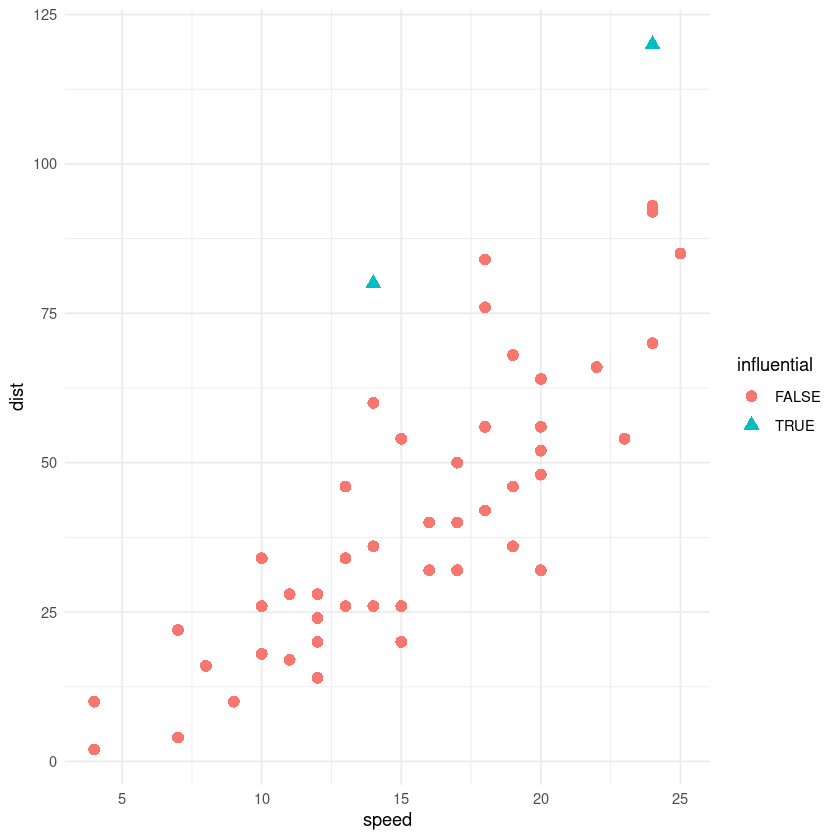

In [36]:
cars %>% 
mutate(influential = row_number() %in% names(influential_points)) %>% 
ggplot(aes(speed, dist)) + 
geom_point(aes(color = influential, shape = influential), size = 3) + 
theme_minimal()

## 3.4 Data Analysis Example

Last chapter we fit an additive regression to the `mtcars` data with `mpg` as the response and `hp` and `am` as predictors. Let’s perform some diagnostics on this model.

In [37]:
mod <- lm(mpg ~ hp + am, data = mtcars)

summary(mod)



Call:
lm(formula = mpg ~ hp + am, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3843 -2.2642  0.1366  1.6968  5.8657 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 26.584914   1.425094  18.655  < 2e-16 ***
hp          -0.058888   0.007857  -7.495 2.92e-08 ***
am           5.277085   1.079541   4.888 3.46e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.909 on 29 degrees of freedom
Multiple R-squared:  0.782,	Adjusted R-squared:  0.767 
F-statistic: 52.02 on 2 and 29 DF,  p-value: 2.55e-10


---
**Equal Variance** and **Linear** Assumption:

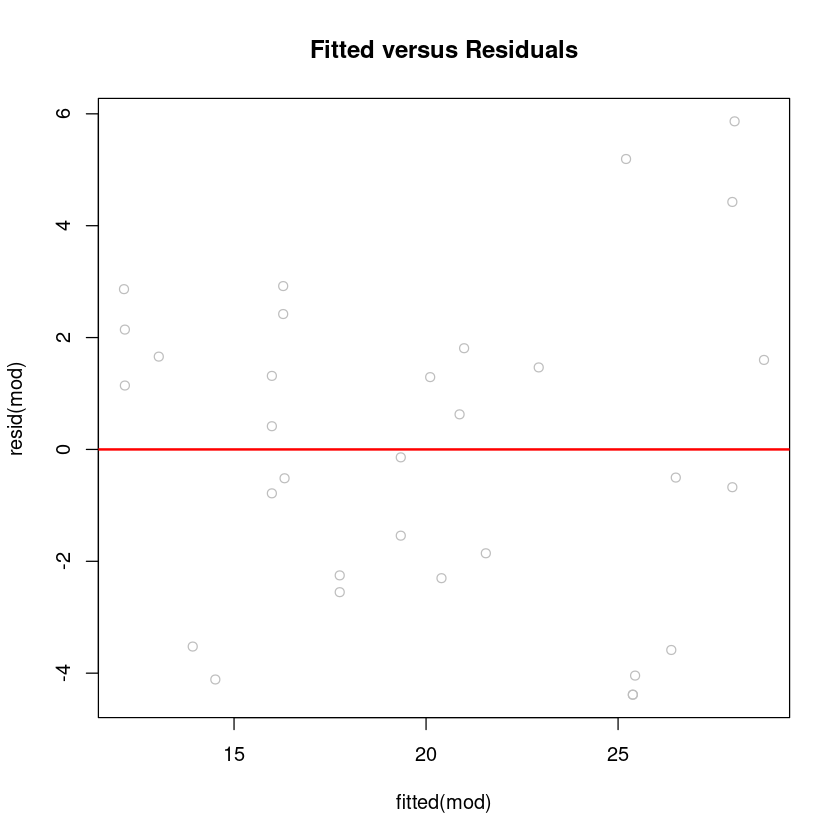

In [38]:
plot(fitted(mod), resid(mod), main = "Fitted versus Residuals", col = "grey", pch = 21)
abline(h = 0, lwd = 2, col = "red")

The fitted versus residuals plot looks good. We don’t see any obvious pattern, and the variance looks roughly constant. (Maybe a little larger for large fitted values, but not enough to worry about.)

In [42]:
# checking for assumption about constant variance using bp test
bptest(mod)


	studentized Breusch-Pagan test

data:  mod
BP = 7.5858, df = 2, p-value = 0.02253


The Breusch-Pagan test verifies this, at least for a small α value ($\alpha$ = 0.01, we fail to reject $H_0$, concludes that the variance of residuals for each point is constant at 0.01 significant level)

---
**Normal** assumption:

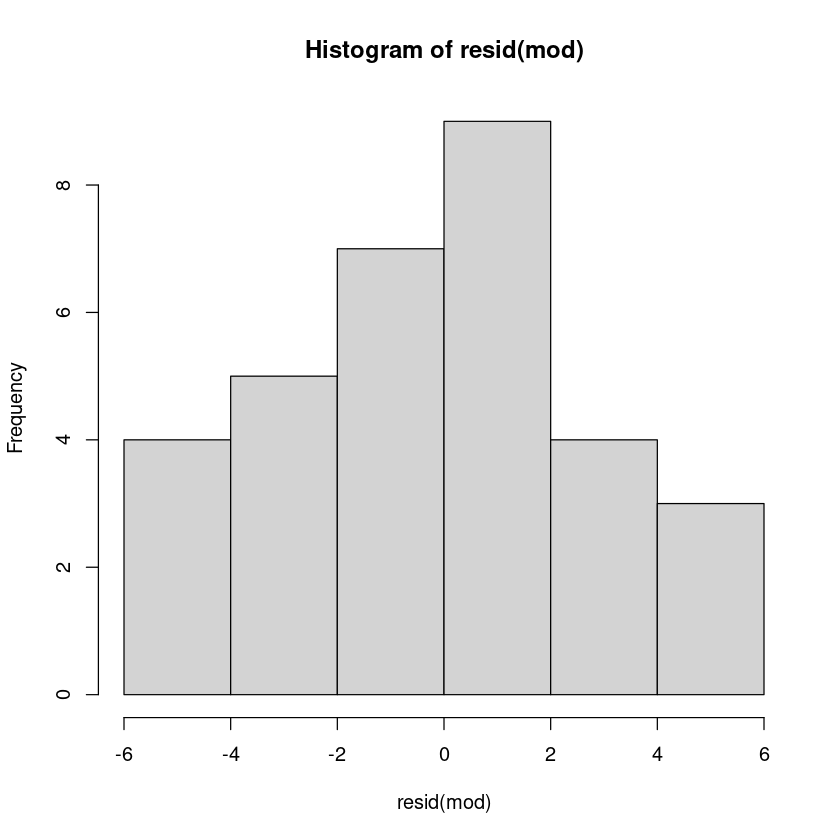

In [46]:
# the sample size is small, so a histogram might not be a good choice here
# but it seems like the residuals are normal
hist(resid(mod))

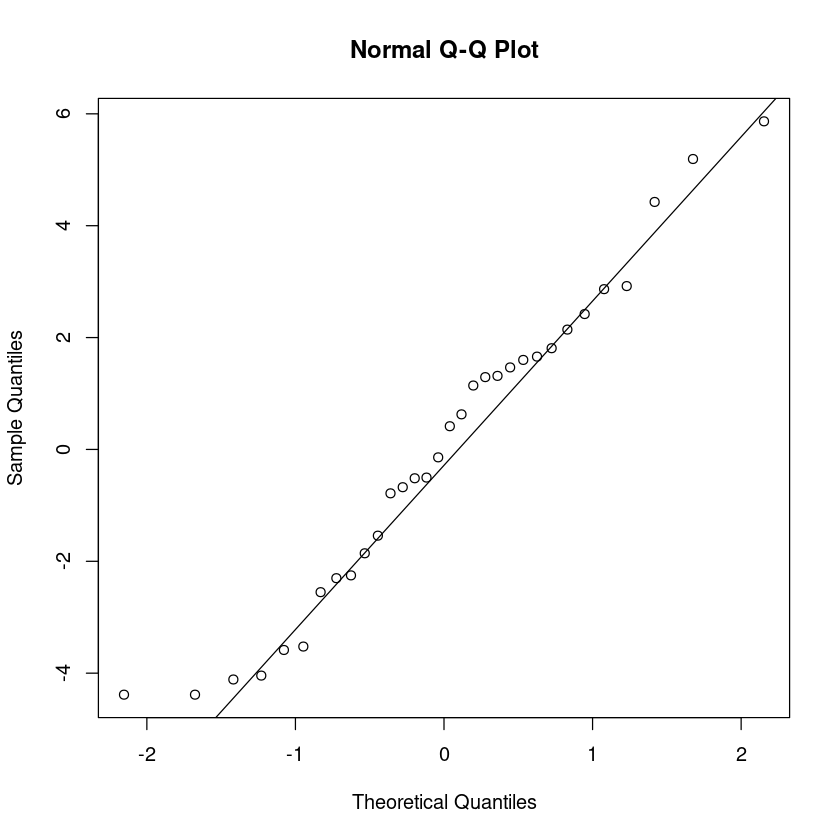

In [39]:
qqnorm(resid(mod))
qqline(resid(mod))

The Q-Q plot looks extremely good and the Shapiro-Wilk test agrees.

In [44]:
# H_0: The residual is sampled from a normal distribution
shapiro.test(resid(mod))


	Shapiro-Wilk normality test

data:  resid(mod)
W = 0.96485, p-value = 0.3706


---
**Unusual** observations:

- Leverage 

In [48]:
leverage <- hatvalues(mod)
leverage

Mazda RX4       Mazda RX4 Wag          Datsun 710      Hornet 4 Drive 
         0.07899294          0.07899294          0.08527830          0.07105790 
  Hornet Sportabout             Valiant          Duster 360           Merc 240D 
         0.05421555          0.07490621          0.10500172          0.12305557 
           Merc 230            Merc 280           Merc 280C          Merc 450SE 
         0.08369686          0.06275899          0.06275899          0.05547273 
         Merc 450SL         Merc 450SLC  Cadillac Fleetwood Lincoln Continental 
         0.05547273          0.05547273          0.06722879          0.07448395 
  Chrysler Imperial            Fiat 128         Honda Civic      Toyota Corolla 
         0.08810179          0.10392567          0.11778118          0.10482053 
      Toyota Corona    Dodge Challenger         AMC Javelin          Camaro Z28 
         0.08182204          0.05339983          0.05339983          0.10500172 
   Pontiac Firebird           Fiat X1-9       Porsche 914-2        Lotus Europa 
         0.05421555          0.10392567          0.08629490          0.07832137 
     Ford Pantera L        Ferrari Dino       Maserati Bora          Volvo 142E 
         0.21412341          0.09383532          0.39293834          0.07924597

In [50]:
# leverage points
which(leverage > 2 * mean(leverage))

Ford Pantera L  Maserati Bora 
            29             31

- Outliers

In [51]:
outliers <- which(abs(rstandard(mod)) > 2)
outliers

Toyota Corolla 
            20

- Influential points

In [53]:
cook_distance <- cooks.distance(mod)

influential_points <- which(cook_distance > 4 / nrow(mtcars))

influential_points

Toyota Corolla  Maserati Bora 
            20             31

In [54]:
mtcars[names(influential_points),]

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Toyota Corolla,33.9,4,71.1,65,4.22,1.835,19.9,1,1,4,1
Maserati Bora,15.0,8,301.0,335,3.54,3.570,14.6,0,1,5,8


We found 2 influential points, interestingly, they are 2 very different cars

Since the diagnostics looked good, there isn’t much need to worry about these two points, but let’s see how much the coefficients change if we remove them.

In [68]:
robust_mod <- lm(mpg ~ hp + am, data = mtcars, subset = !rownames(mtcars) %in% names(influential_points))
coef(robust_mod)

(Intercept)          hp          am 
27.22190933 -0.06286249  4.29765867

In [69]:
# compare the model that fits all the data
coef(mod)

(Intercept)          hp          am 
 26.5849137  -0.0588878   5.2770853

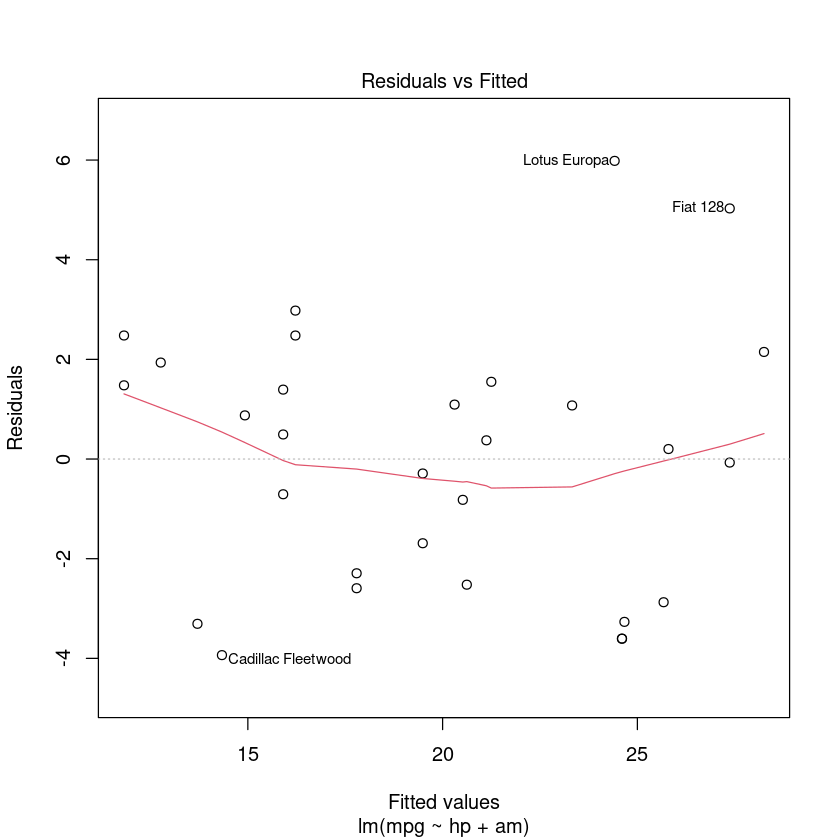

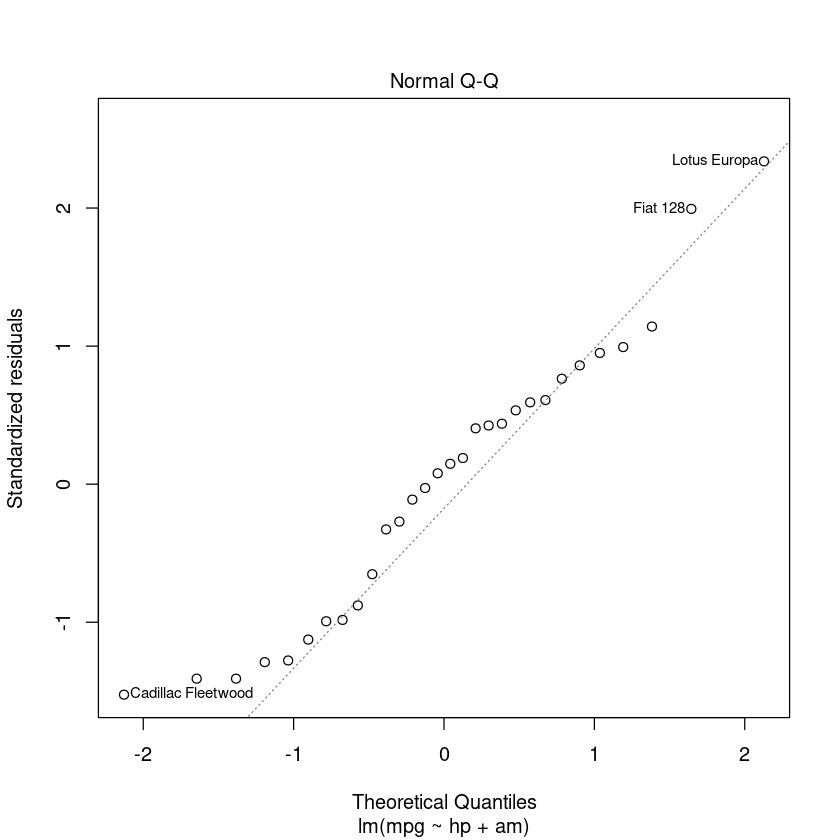

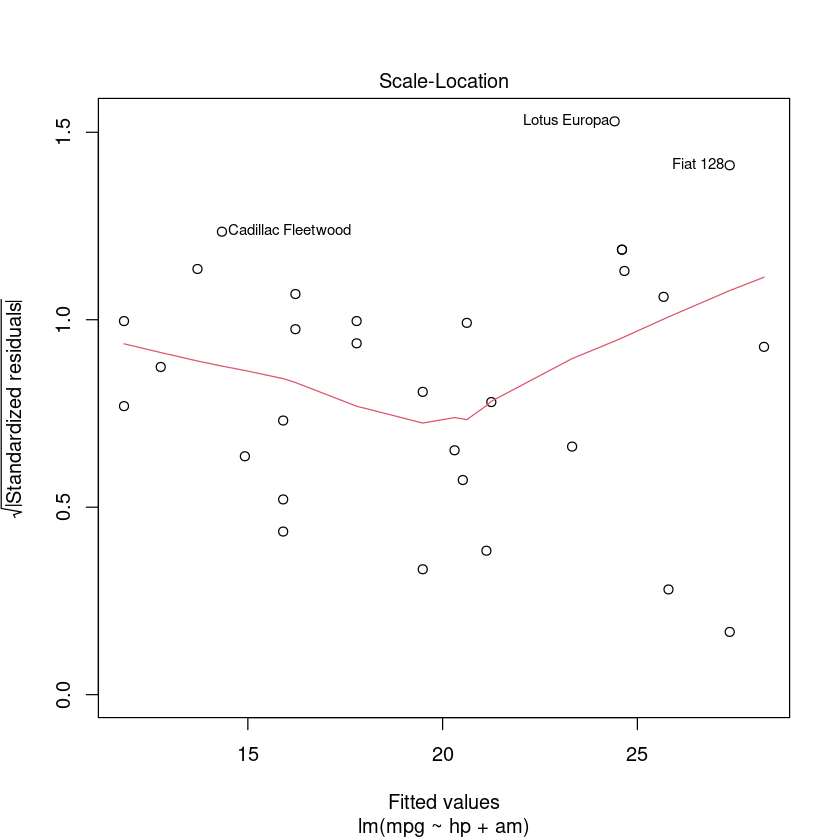

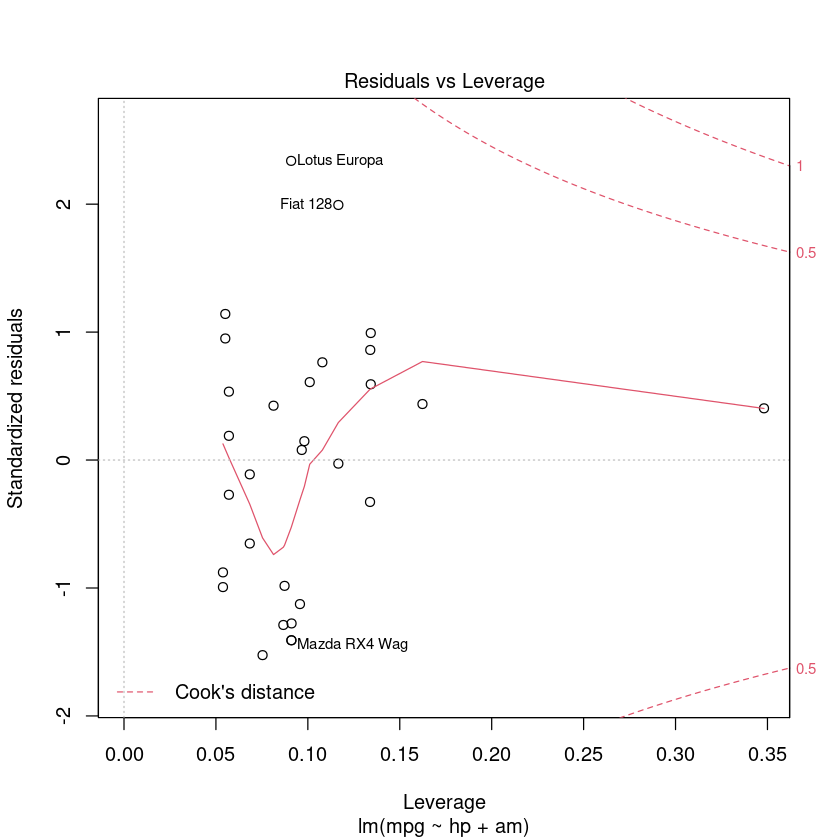

In [71]:
# diagnostic plot
plot(robust_mod)

# Exercises

**Exercises**: <https://www.studocu.com/en-us/document/university-of-illinois-at-urbana-champaign/methods-of-applied-statistics/assignments/homework-5-solution/1892002/view>

----
**Exercise 1**

In [4]:
library(tidyverse)
library(faraway)
library(broom)

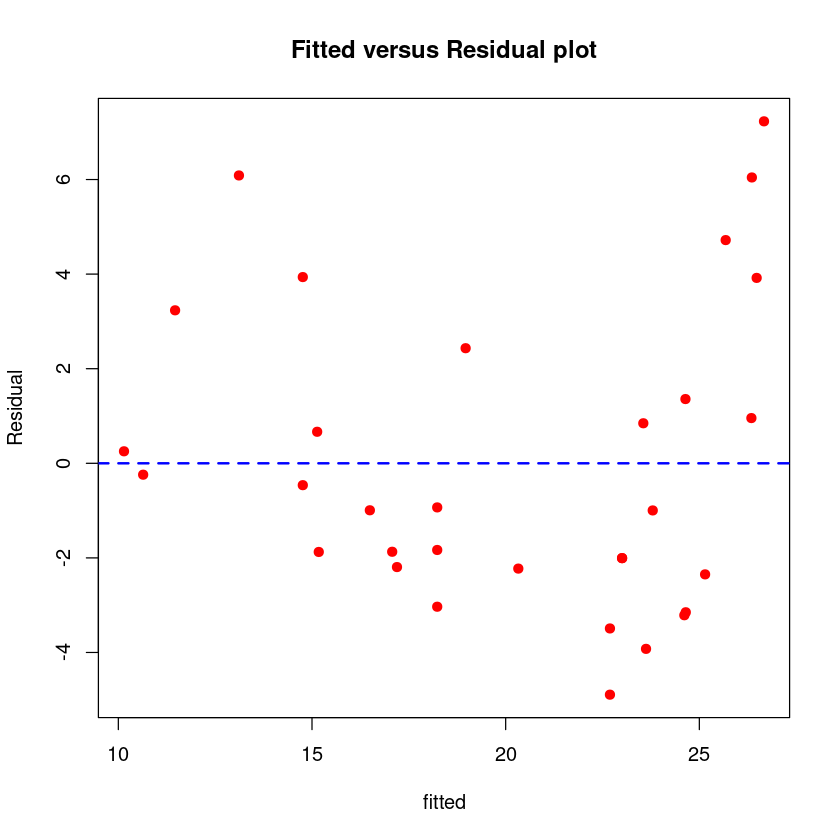

In [5]:
# fitted vs residual plot, given a model
fvr_plot <- function(mod, pointcol = "red", linecol = "blue") {
  plot(fitted(mod), resid(mod),
    col = pointcol, main = "Fitted versus Residual plot",
		pch = 20, cex = 1.5, 
    ylab = "Residual", xlab = "fitted"
  )
  abline(h = 0, col = linecol, lwd = 2, lty = 2)
}

mtcars_mod <- lm(mpg ~ disp, data = mtcars)

fvr_plot(mtcars_mod)

In [6]:
# bp test for constant variance: H_0: equal variance
lmtest::bptest(mtcars_mod)


	studentized Breusch-Pagan test

data:  mtcars_mod
BP = 2.9164, df = 1, p-value = 0.08768


fail to reject $H_0$ at 0.05 significant level. Concludes that the variance of response for each combination of predictor(s) is constant

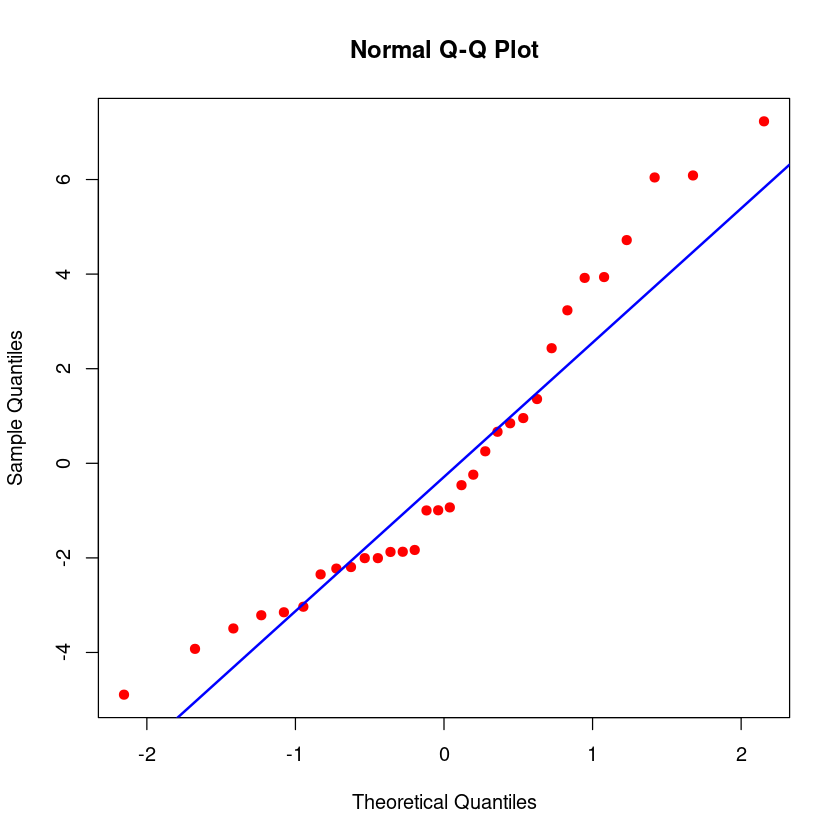

In [7]:
# qq plot, given a model
qq_plot <- function(mod, pointcol = "red", linecol = "blue") {
	qqnorm(resid(mod), pch = 20, cex = 1.5, col = pointcol)
	qqline(resid(mod), lwd = 2, col = linecol)
}

qq_plot(mtcars_mod)

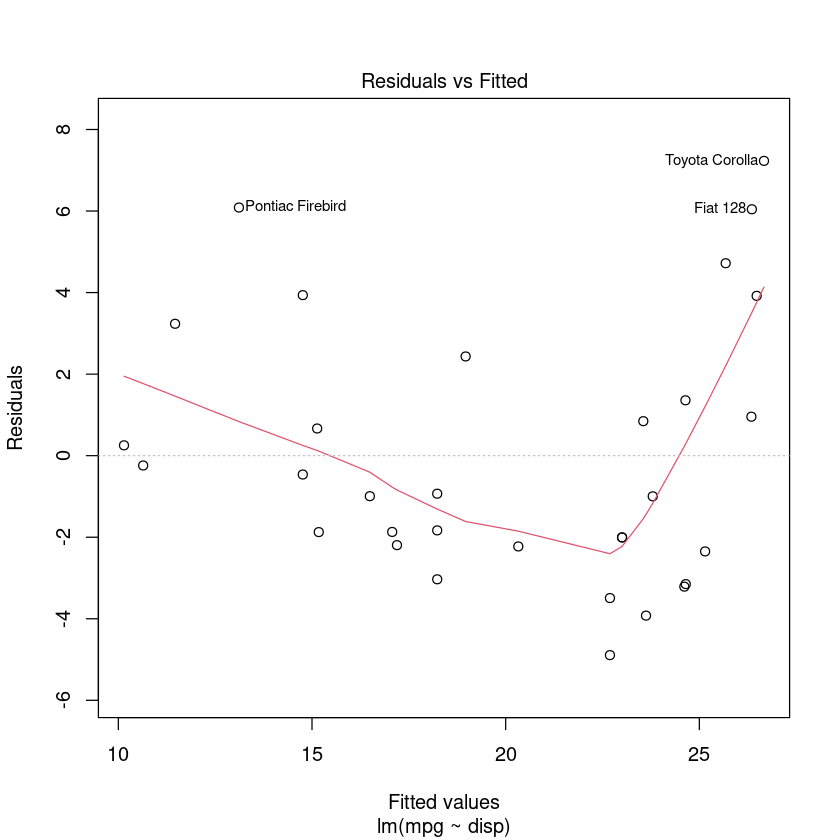

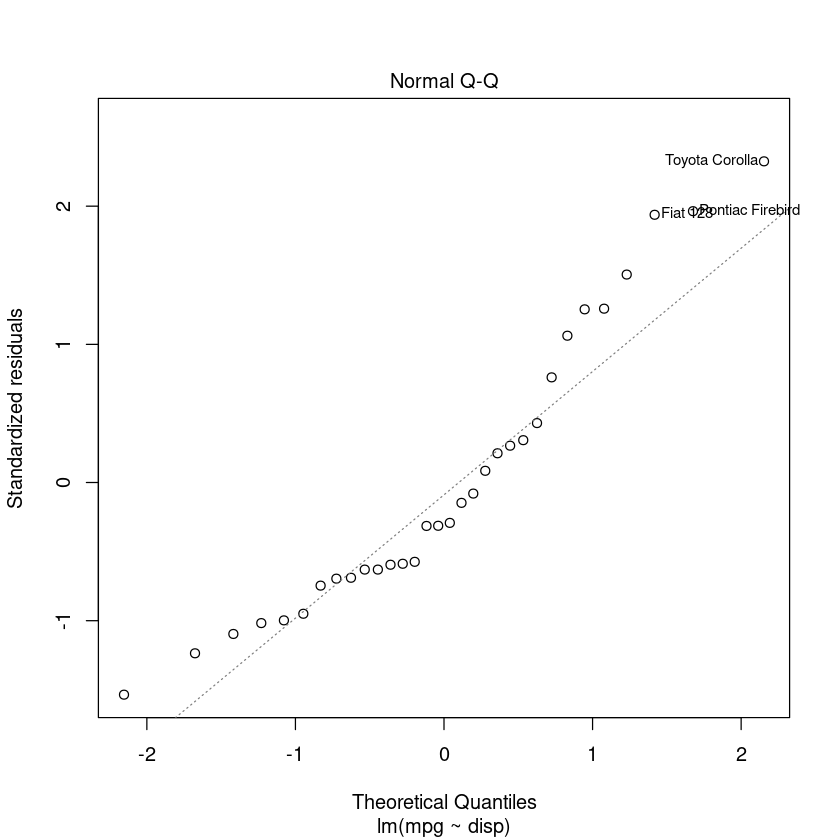

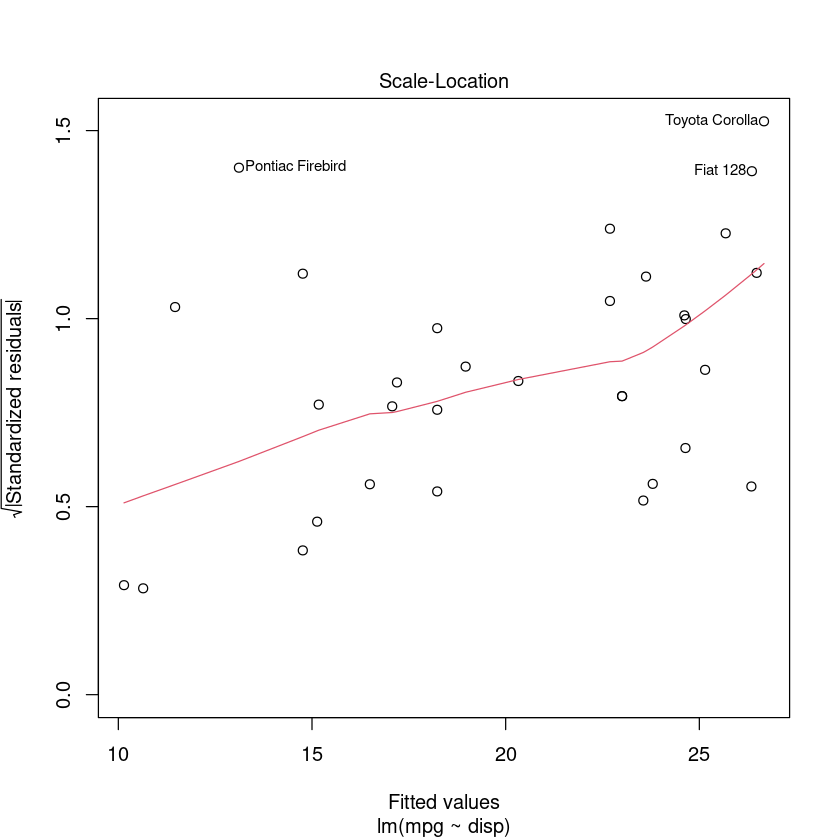

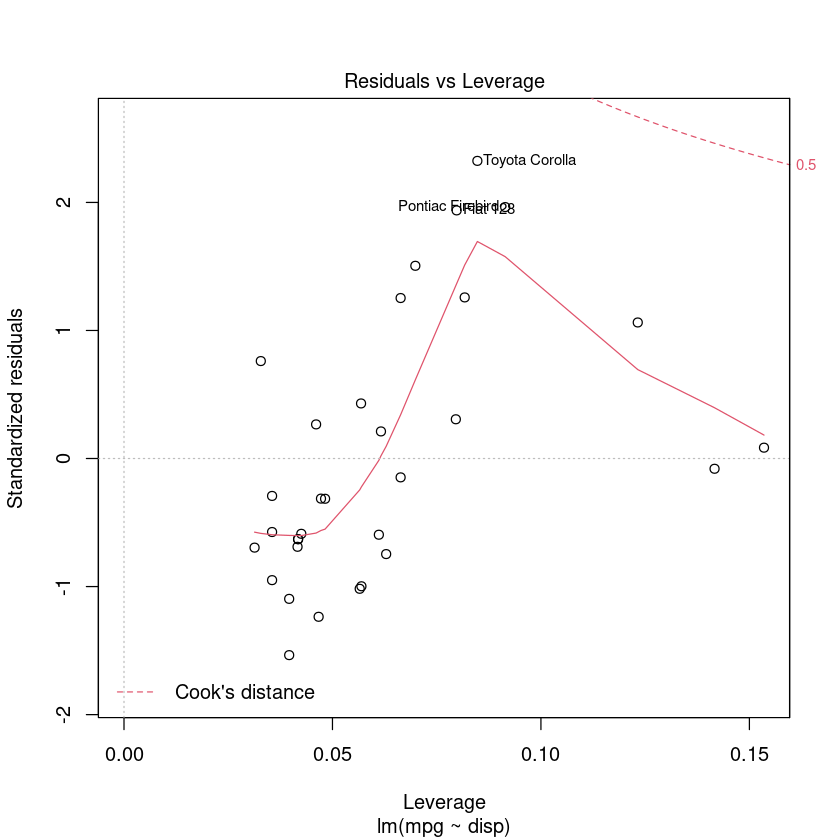

In [8]:
plot(mtcars_mod)

---
work on `faraway::swiss` dataset

In [9]:
data(swiss)

swiss %>% glimpse()

Rows: 47
Columns: 6
$ Fertility        <dbl> 80.2, 83.1, 92.5, 85.8, 76.9, 76.1, 83.8, 92.4, 82...
$ Agriculture      <dbl> 17.0, 45.1, 39.7, 36.5, 43.5, 35.3, 70.2, 67.8, 53...
$ Examination      <int> 15, 6, 5, 12, 17, 9, 16, 14, 12, 16, 14, 21, 14, 1...
$ Education        <int> 12, 9, 5, 7, 15, 7, 7, 8, 7, 13, 6, 12, 7, 12, 5, ...
$ Catholic         <dbl> 9.96, 84.84, 93.40, 33.77, 5.16, 90.57, 92.85, 97....
$ Infant.Mortality <dbl> 22.2, 22.2, 20.2, 20.3, 20.6, 26.6, 23.6, 24.9, 21...


In [12]:
swiss_mod <- lm(Fertility ~ ., data = swiss)
summary(swiss_mod)


Call:
lm(formula = Fertility ~ ., data = swiss)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2743  -5.2617   0.5032   4.1198  15.3213 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      66.91518   10.70604   6.250 1.91e-07 ***
Agriculture      -0.17211    0.07030  -2.448  0.01873 *  
Examination      -0.25801    0.25388  -1.016  0.31546    
Education        -0.87094    0.18303  -4.758 2.43e-05 ***
Catholic          0.10412    0.03526   2.953  0.00519 ** 
Infant.Mortality  1.07705    0.38172   2.822  0.00734 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.165 on 41 degrees of freedom
Multiple R-squared:  0.7067,	Adjusted R-squared:  0.671 
F-statistic: 19.76 on 5 and 41 DF,  p-value: 5.594e-10


---
checking for **linear** and **equal variance** assumptions

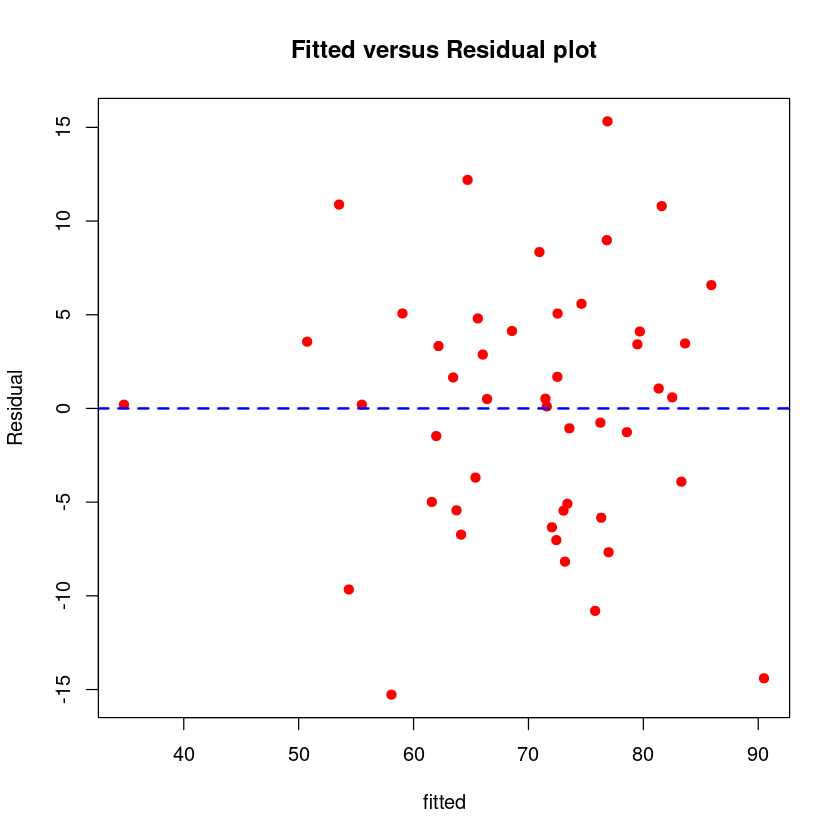

In [13]:
fvr_plot(swiss_mod)

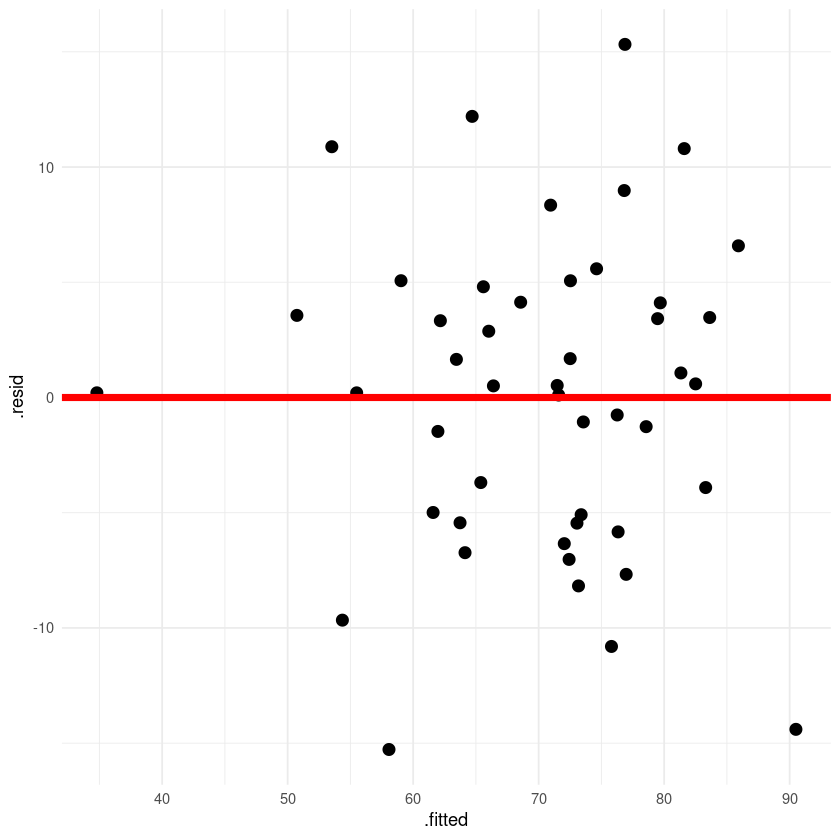

In [14]:
swiss_mod %>% 
  augment() %>% 
  ggplot(aes(.fitted, .resid)) + 
  geom_point(size = 3) +
  geom_hline(yintercept = 0, size = 2, color = "red") + 
  theme_minimal()

In [15]:
lmtest::bptest(swiss_mod)


	studentized Breusch-Pagan test

data:  swiss_mod
BP = 5.8511, df = 5, p-value = 0.321


The fitted versus residuals looks good, and Breusch-Pagan Test does not reject $H_0$, so we choose to believe that the constant variance assumption is not violated

---
Checking for **normal** assumption

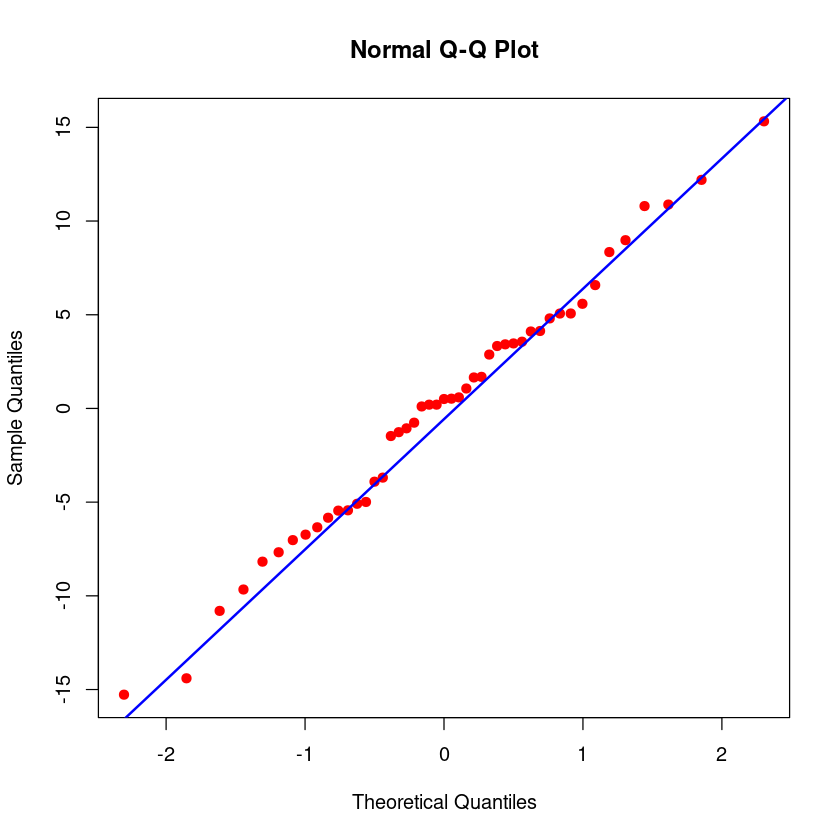

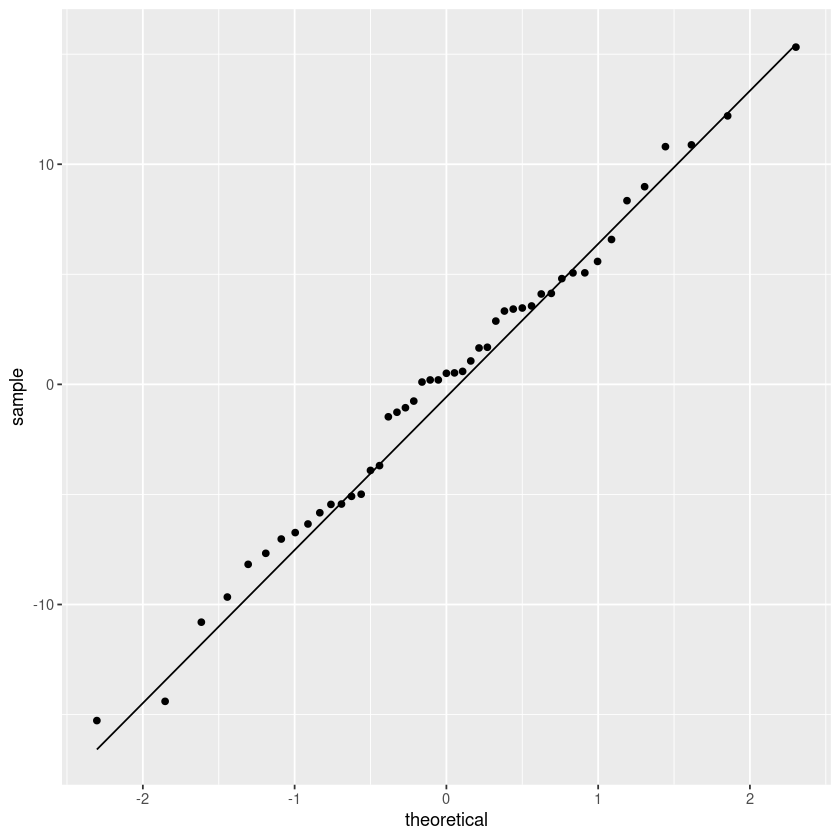

In [16]:
qq_plot(swiss_mod)

swiss_mod %>% 
  augment() %>% 
  ggplot(aes(sample = .resid)) + 
  geom_qq() + 
  geom_qq_line()

In [17]:
shapiro.test(resid(swiss_mod))


	Shapiro-Wilk normality test

data:  resid(swiss_mod)
W = 0.98892, p-value = 0.9318


The points are very close to the line in the Q-Q plot, and The shapiro-Wilk test does not reject $H_0$, so we choose to believe that the normality assumption is not violated.

---
Find leverage obseravations, which potentially influence the model fit

In [19]:
leverage <- hatvalues(swiss_mod)

which(leverage > 2 * mean(leverage))

La Vallee V. De Geneve 
          19           45

---
Find influential points

In [20]:
cooks_distance <- cooks.distance(swiss_mod)
n <- nrow(swiss)
cooks_distance[cooks_distance > 4 / n]

Porrentruy      Sierre   Neuchatel Rive Droite Rive Gauche 
  0.2077343   0.1476237   0.1249500   0.1024707   0.1123648

In [23]:
swiss_mod_without_influential <- lm(Fertility ~ ., data = swiss, subset = cooks_distance <= 4 / n)

# relative change of coefficents with and without influential observations
(coef(swiss_mod_without_influential) - coef(swiss_mod)) / coef(swiss_mod) 

(Intercept)      Agriculture      Examination        Education 
    -0.007032738      0.267753687      0.938557986     -0.207218466 
        Catholic Infant.Mortality 
    -0.054240567      0.260549623

In [26]:
# predicted values for influential observations using 2 different models
influentials <- swiss %>% filter(cooks_distance > 4 / n)

predict_wiss_mod <- predict(swiss_mod, influentials)
predict_wiss_mod

Porrentruy      Sierre   Neuchatel Rive Droite Rive Gauche 
   90.50011    76.87869    53.51934    54.36209    58.07426

In [27]:
predict_swiss_mod_without_inf <- predict(swiss_mod_without_influential, influentials)
predict_swiss_mod_without_inf

Porrentruy      Sierre   Neuchatel Rive Droite Rive Gauche 
   94.43980    76.33683    55.89622    57.92582    61.32012

In [28]:
# relative change
(predict_wiss_mod - predict_swiss_mod_without_inf) / predict_swiss_mod_without_inf

Porrentruy       Sierre    Neuchatel  Rive Droite  Rive Gauche 
-0.041716447  0.007098242 -0.042523082 -0.061522391 -0.052933112

---
Excercise 3, 4, 5

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



Rows: 38
Columns: 3
$ life   <dbl> 70.5, 53.5, 65.0, 76.5, 70.0, 71.0, 60.5, 51.5, 78.0, 76.0, ...
$ tv     <dbl> 4.0, 315.0, 4.0, 1.7, 8.0, 5.6, 15.0, 503.0, 2.6, 2.6, 44.0,...
$ doctor <int> 370, 6166, 684, 449, 643, 1551, 616, 36660, 403, 346, 2471, ...



	studentized Breusch-Pagan test

data:  tv_mod
BP = 0.15641, df = 1, p-value = 0.6925


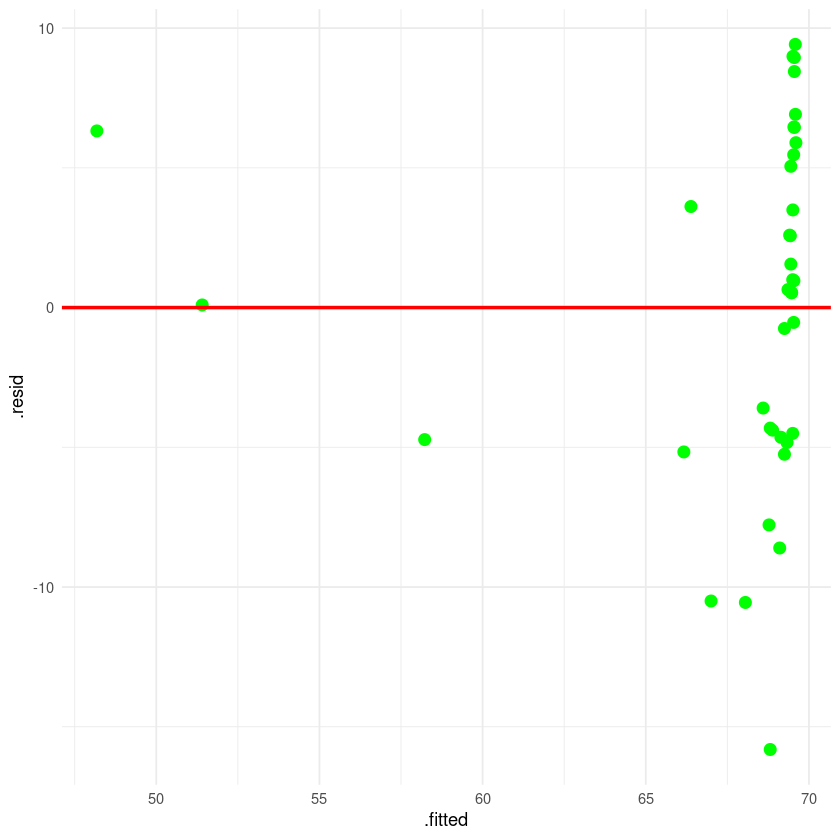

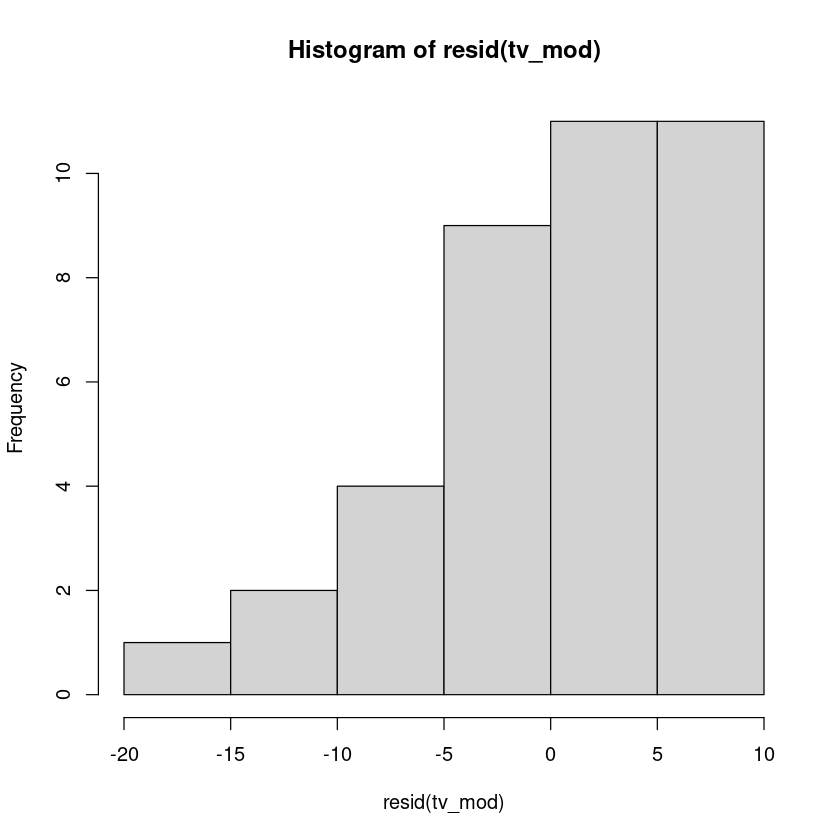


	Shapiro-Wilk normality test

data:  resid(tv_mod)
W = 0.96076, p-value = 0.201


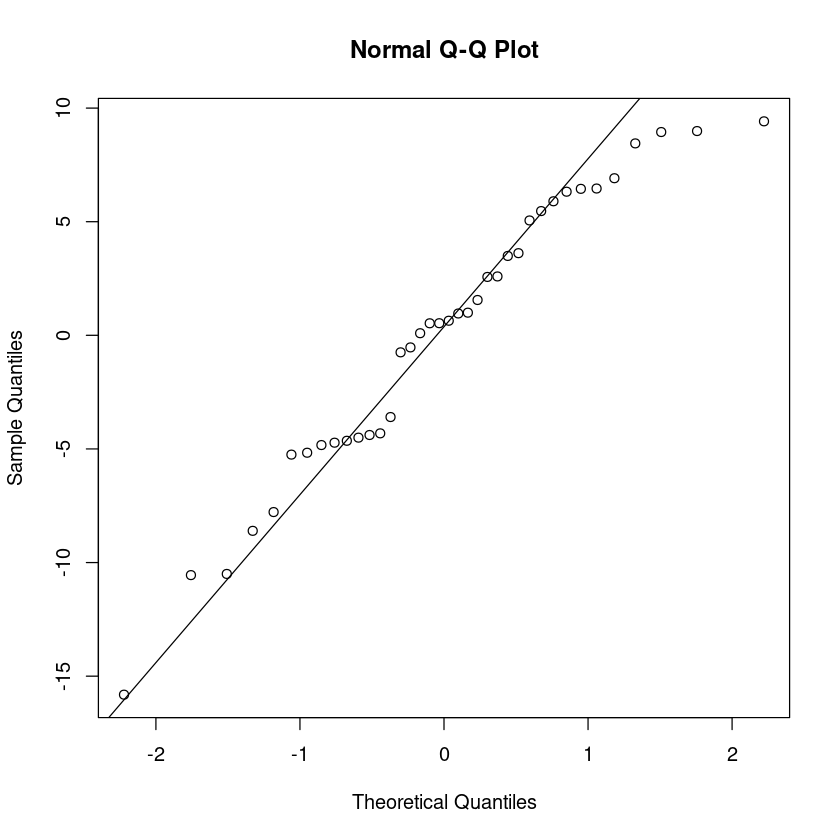

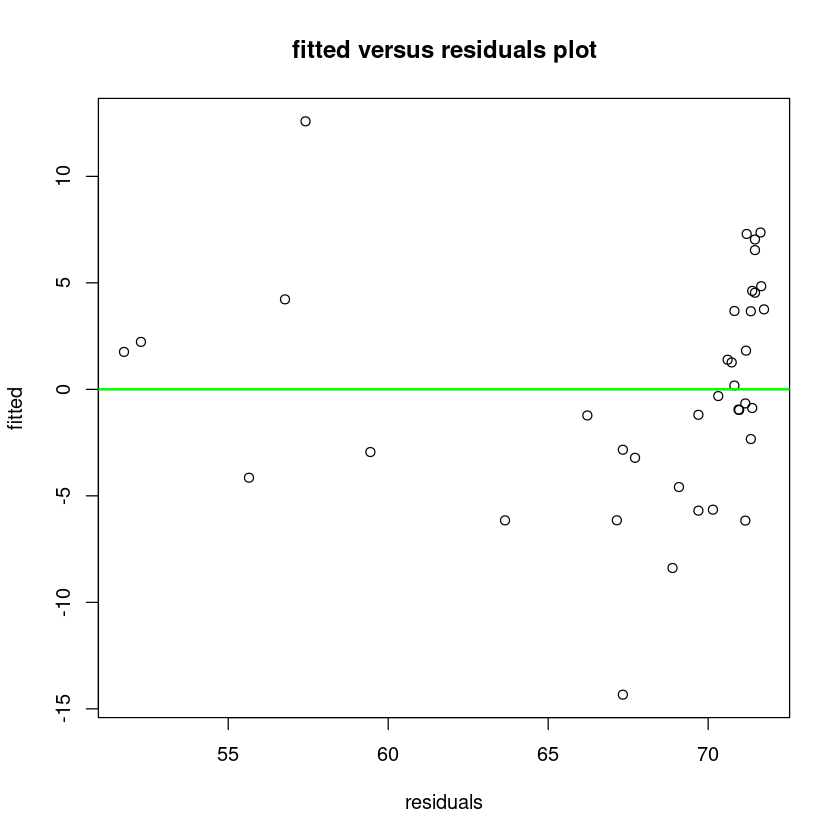

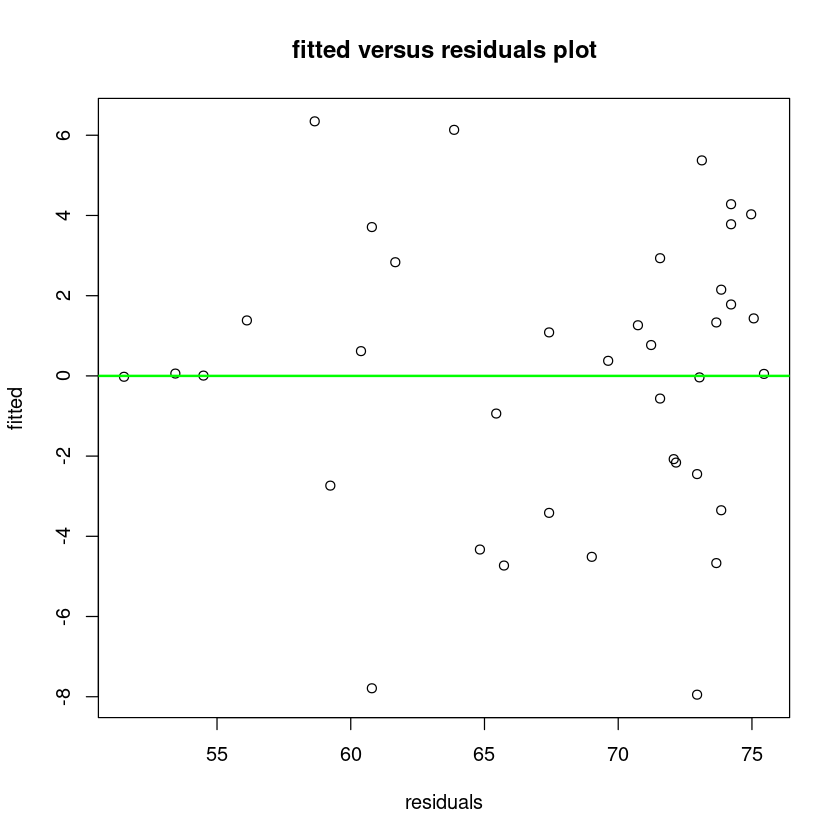

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,32,457.1540,NA,NA,NA,NA
2,30,428.2544,2,28.89961,1.012235,0.3754824


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,34,1027.849,NA,NA,NA,NA
2,32,457.154,2,570.6948,19.97383,2.344948e-06


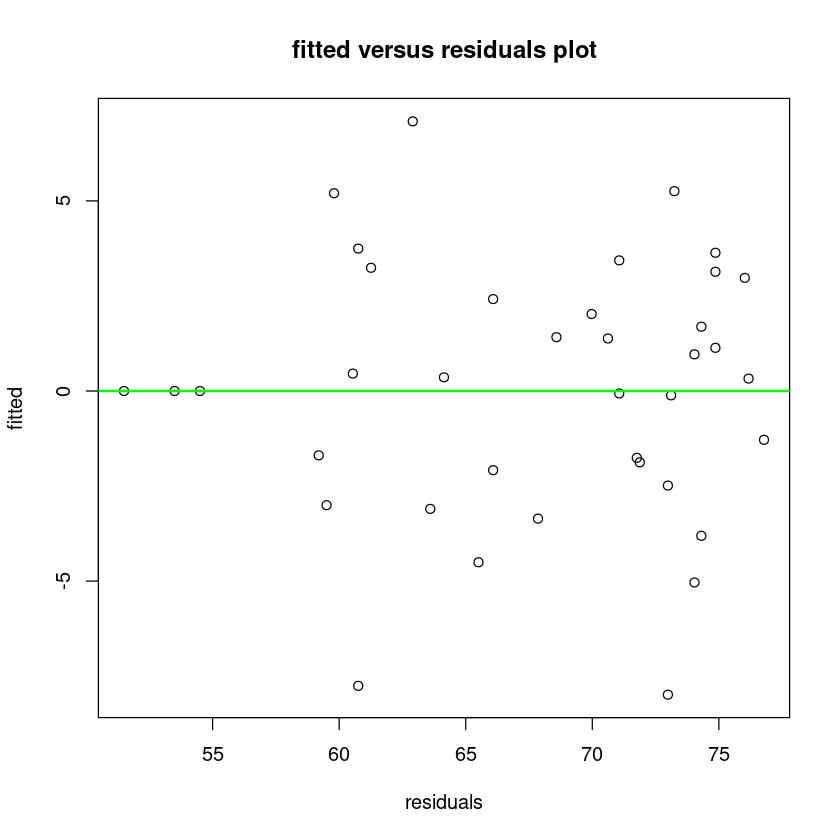


	Shapiro-Wilk normality test

data:  resid(tv_mod_poly5)
W = 0.97473, p-value = 0.5338


,life,tv,doctor
,<dbl>,<dbl>,<int>
Bangladesh,53.5,315,6166
Ethiopia,51.5,503,36660
Kenya,61.0,96,7615
KoreaNorth,70.0,90,370
Myanmar,54.5,592,3485


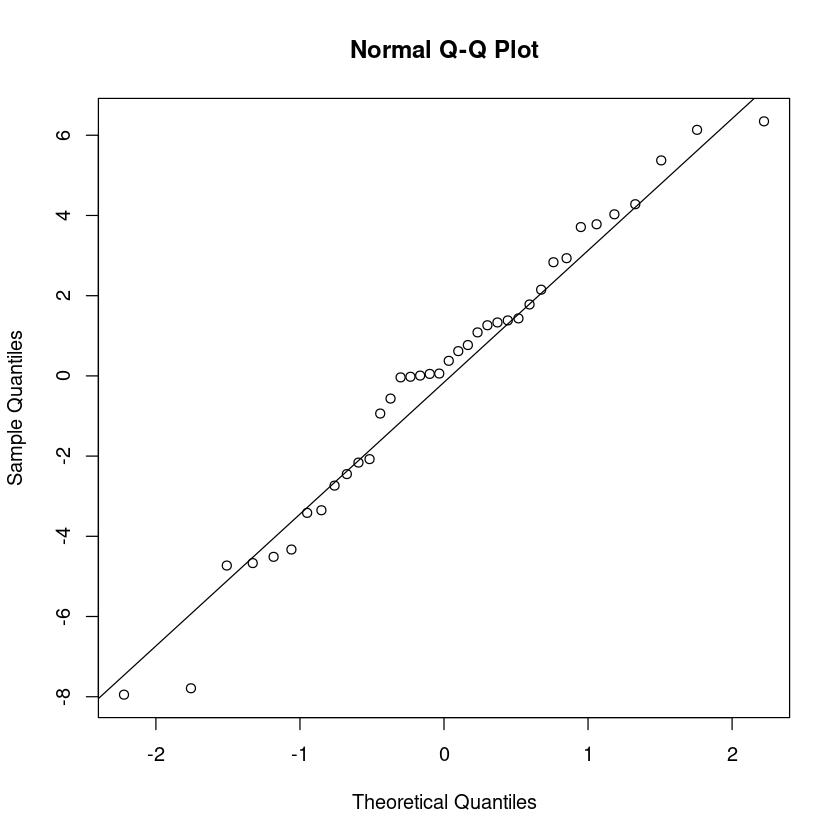

In [1]:
library(tidyverse)
library(faraway)
library(broom)


data(tvdoctor)



tvdoctor %>% glimpse()

tv_mod <- lm(life ~ tv, data = tvdoctor)


# fitted versus residual plot
tv_mod %>% 
	augment()  %>% 
	ggplot(aes(.fitted, .resid)) + 
	geom_point(size = 3, color = "green") + 
	geom_hline(yintercept = 0, size = 1, color = "red") + 
	theme_minimal()


# test for constant variance assumption
lmtest::bptest(tv_mod)

# check for normality assumption

# histogram of residuals
hist(resid(tv_mod))


# qq plot of residuals
qqnorm(resid(tv_mod))
qqline(resid(tv_mod))


# Shapiro-Wilk test for normality of residuals
shapiro.test(resid(tv_mod))

theme_set(theme_minimal())


# try poly 3, 5, 7 to fit data# try poly 3, 5, 7 to fit data# try poly 3, 5, 7 to fit data

tv_mod_poly3 <- lm(life ~ poly(tv, 3), data = tvdoctor)
plot(fitted(tv_mod_poly3), resid(tv_mod_poly3),
main = "fitted versus residuals plot",
xlab = "residuals", ylab = "fitted")
abline(h = 0, lwd = 2, col = "green")


tv_mod_poly5 <- lm(life ~ poly(tv, 5), data = tvdoctor)
plot(fitted(tv_mod_poly5), resid(tv_mod_poly5),
main = "fitted versus residuals plot",
xlab = "residuals", ylab = "fitted")
abline(h = 0, lwd = 2, col = "green")

tv_mod_poly7 <- lm(life ~ poly(tv, 7), data = tvdoctor)
plot(fitted(tv_mod_poly7), resid(tv_mod_poly7),
		 main = "fitted versus residuals plot",
		 xlab = "residuals", ylab = "fitted")
abline(h = 0, lwd = 2, col = "green")

# Hierarchy


# is poly7 signifcant, compare to poly5? NO
anova(tv_mod_poly5, tv_mod_poly7)

# is poly5 significant, compare to poly3? YES --> chose poly5
anova(tv_mod_poly3, tv_mod_poly5)


# check normality assumption for poly5

# QQ plot
qqnorm(resid(tv_mod_poly5))
qqline(resid(tv_mod_poly5))

# Shapiro-Wilk Test
shapiro.test(resid(tv_mod_poly5))
# p.value > 0.05, so fail to reject H_0, choose to believe normality assumption is not violated


# Identify influential observations for model poly5 using cooks distance
cd <- cooks.distance(tv_mod_poly5)
idx <- which(cd > 4 / nrow(tvdoctor))

tvdoctor[idx,]


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select




Rows: 62
Columns: 2
$ body  <dbl> 3.385, 0.480, 1.350, 465.000, 36.330, 27.660, 14.830, 1.040, ...
$ brain <dbl> 44.50, 15.50, 8.10, 423.00, 119.50, 115.00, 98.20, 5.50, 58.0...


,body,brain
,<dbl>,<dbl>
African elephant,6654,5712


,body,brain
,<dbl>,<dbl>
Lesser short-tailed shrew,0.005,0.14


,body,brain
,<dbl>,<dbl>
Lesser short-tailed shrew,0.005,0.14


,body,brain
,<dbl>,<dbl>
African elephant,6654,5712


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.8726621,0.8705398,334.7198,411.1872,1.542935e-28,1,-447.3819,900.7638,907.1452,6722239,60,62


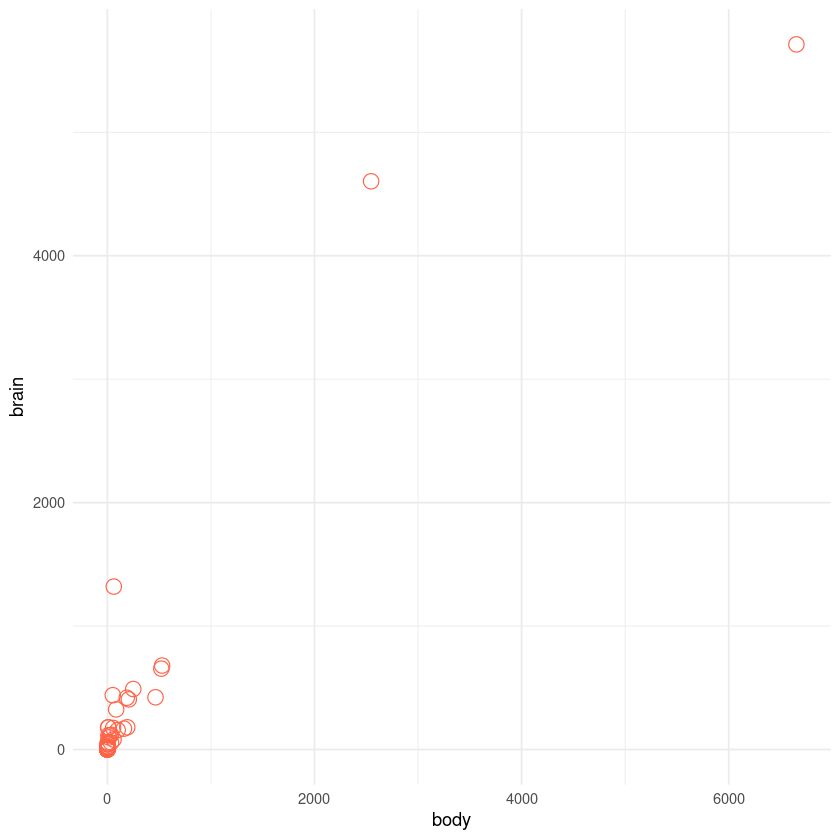


	studentized Breusch-Pagan test

data:  mammals_mod
BP = 12.537, df = 1, p-value = 0.0003989


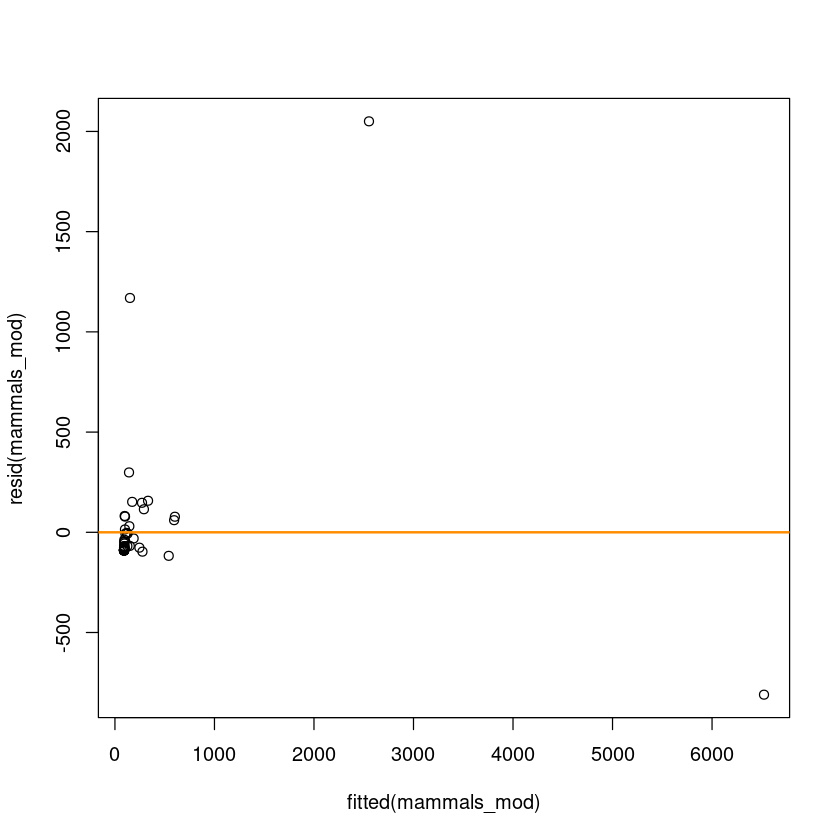

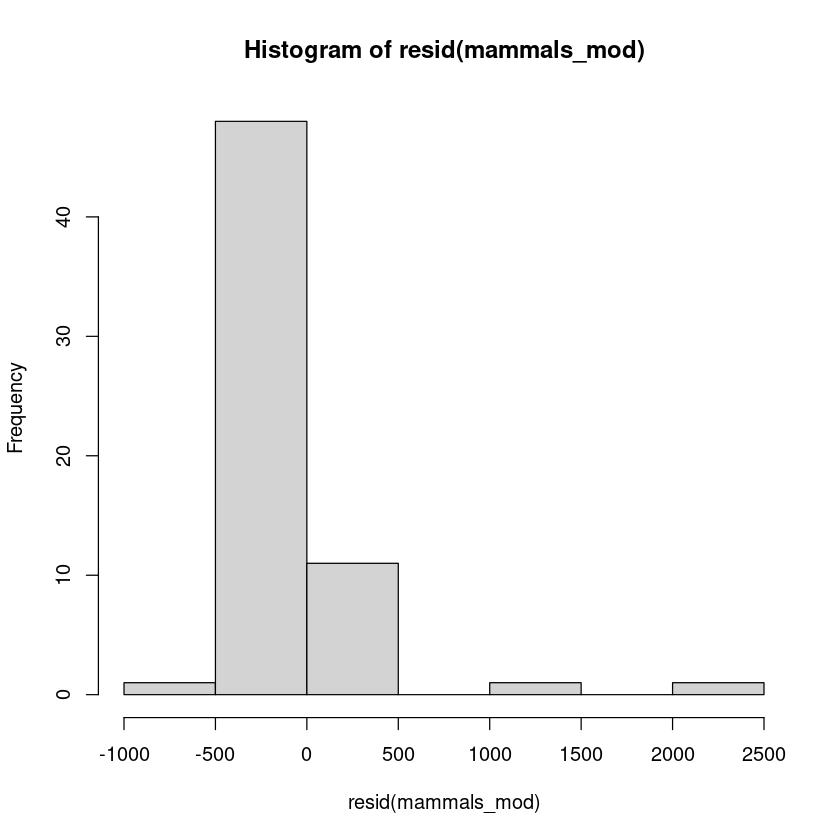

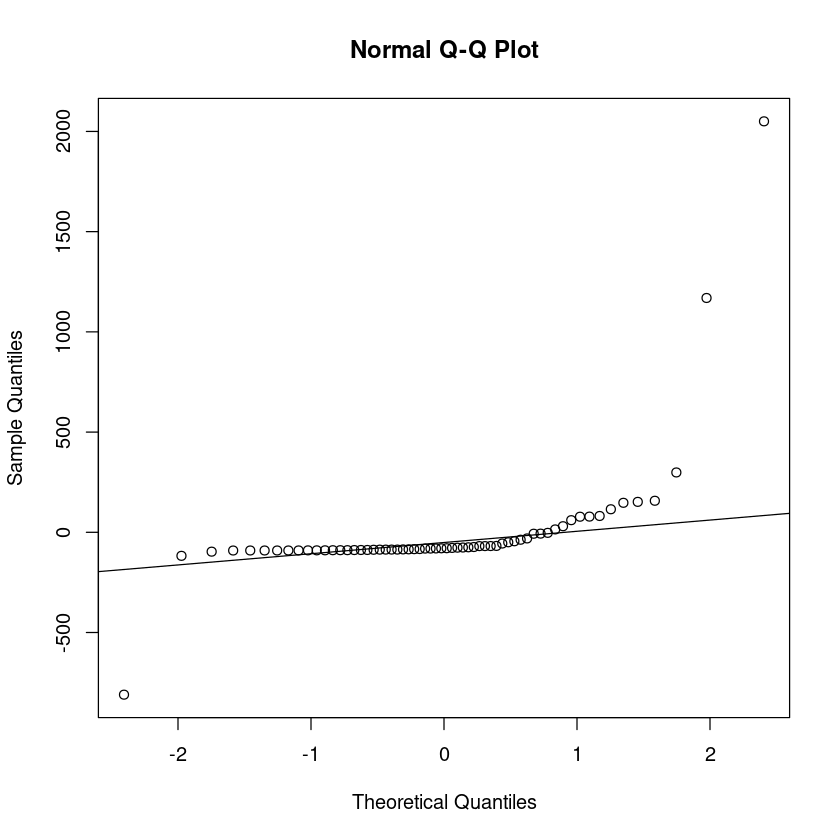

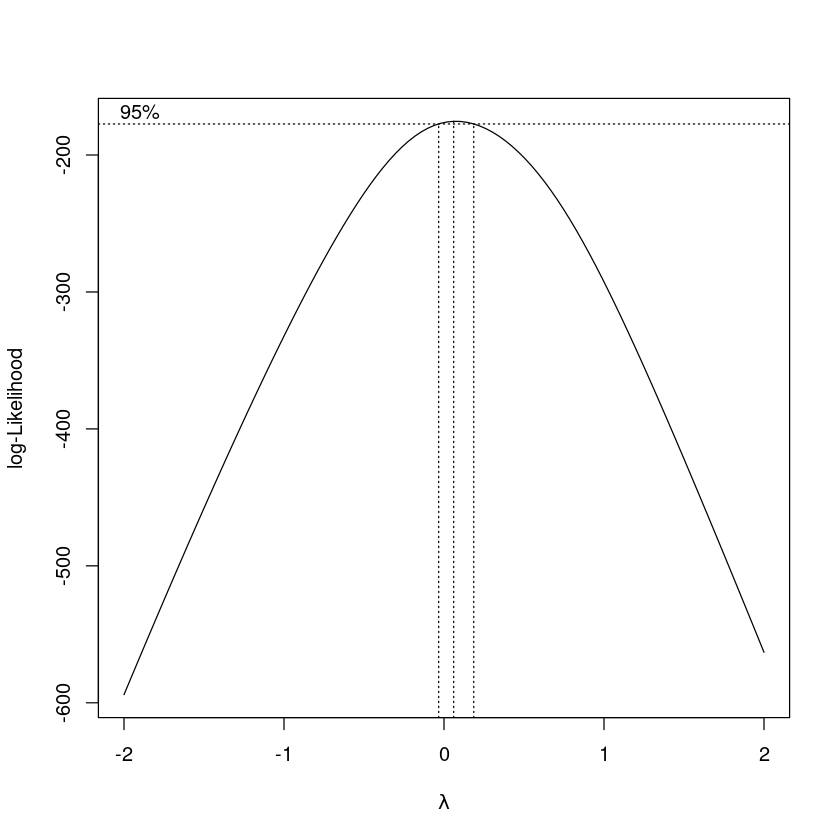

`geom_smooth()` using formula 'y ~ x'



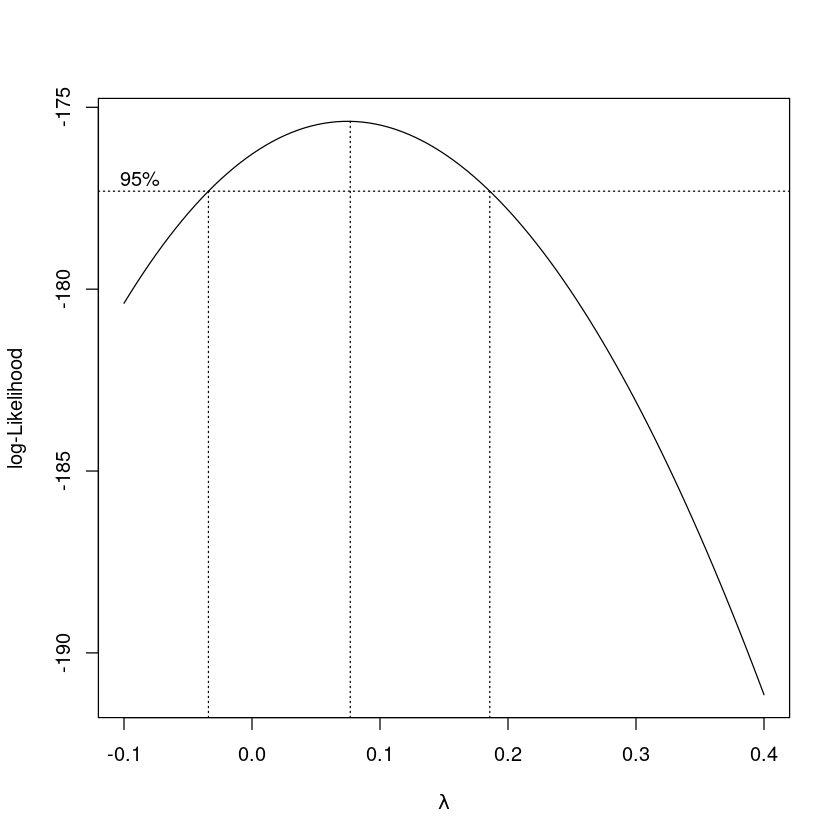

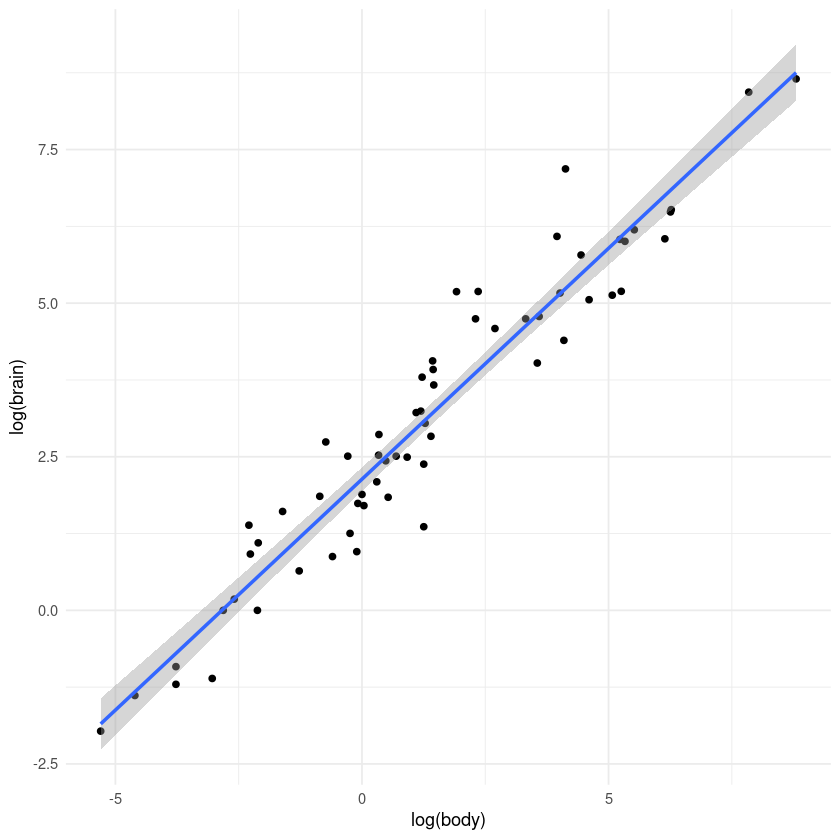

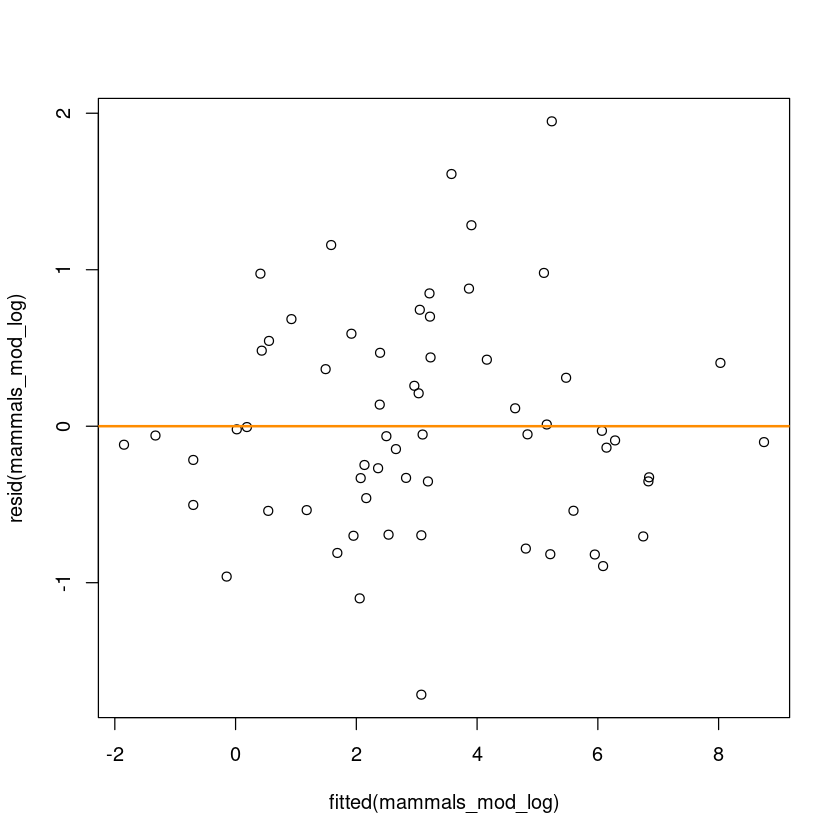

,fit,lwr,upr
1,32.88224,5.107641,211.6911


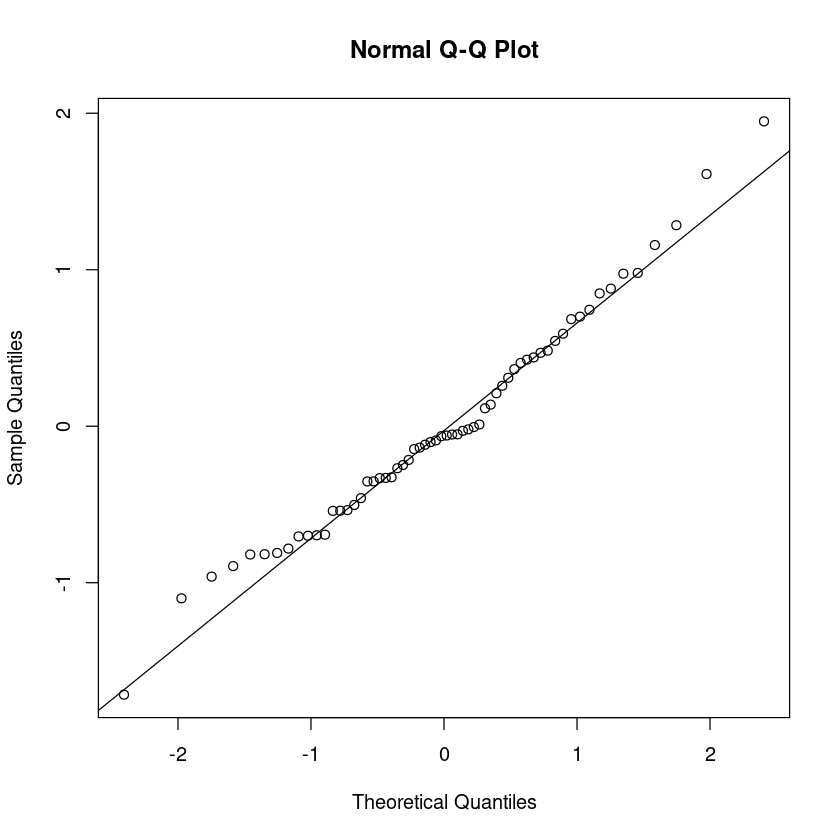

In [2]:
library(MASS)

# average body weight (kg) and the average brain brain weight (g)
# for 62 species of land mammals
mammals %>% glimpse()


mammals %>% 
	ggplot(aes(body, brain)) + 
	geom_point(shape = 21, size = 4, color = "tomato")


# heaviest mammals
mammals %>% slice_max(body)
# smallest body mammals
mammals %>% slice_min(body)


# smallest brain size
mammals %>% slice_min(brain)
# largest brain size
mammals %>% slice_max(brain)


# fit a linear model brain ~ body
mammals_mod <- lm(brain ~ body, data = mammals)

# the regression is significant, p.value is small, close to 0
mammals_mod %>% glance()


# model diagnostic

## linear and constant variance
plot(fitted(mammals_mod), resid(mammals_mod))
abline(h = 0, lwd = 2, col = "darkorange")

lmtest::bptest(mammals_mod)
# p-value is small, reject H), the constant variance assumption is viloated

# normality assumption

# in this problem, a histogram of residuals is not useful
hist(resid(mammals_mod))


qqnorm(resid(mammals_mod))
qqline(resid(mammals_mod))

# qqplot does not look good, some values are extrame far away from the line


# variance of residuals increasing, and brain size is positive
# so try Box-cox transformation on brain size

boxcox(mammals_mod)

boxcox(mammals_mod, lambda = seq(-0.1, 0.4, 0.01))

# 0 is 95% confidence interval of lambda and close to maximum likelihood point
# choose lambda = 0  ===> log function

# Fit a linear model: log(brain) ~ log(body)
mammals_mod_log <- lm(log(brain) ~ log(body), data = mammals)


# Seems to be reasonable, a linear relationship between log variables are approriate
mammals %>% 
	ggplot(aes(log(body), log(brain))) +
	geom_point() +
	geom_smooth(method = "lm")

# check linear and constant assumption

# fitted versus residuals plot looks good
plot(fitted(mammals_mod_log), resid(mammals_mod_log))
abline(h = 0, lwd = 2, col = "darkorange")

# check for normality assumption

# the qq plot looks nice
qqnorm(resid(mammals_mod_log))
qqline(resid(mammals_mod_log))


## 99% prediction interval for Pikachu with weight (13.4 pounds)

predict(mammals_mod_log, tibble(body = 13.4 / 2.2), interval = "prediction", level = .99) %>% exp()


-- Column specification ----------------------------------------------------------------------------------------------------------------------------------------------------------------------
cols(
  Make = col_character(),
  Model = col_character(),
  ID = col_character(),
  disp = col_double(),
  type = col_character(),
  horse = col_double(),
  cyl = col_double(),
  lockup = col_character(),
  drive = col_character(),
  weight = col_double(),
  axleratio = col_double(),
  nvratio = col_double(),
  THC = col_double(),
  CO = col_double(),
  CO2 = col_double(),
  mpg = col_double()
)




Rows: 4,411
Columns: 16
$ Make      <chr> "aston martin", "aston martin", "aston martin", "aston ma...
$ Model     <chr> "DB9", "DB9", "Rapide S", "Rapide S", "V12 Vantage S", "V...
$ ID        <chr> "143TT1042", "143TT1042", "410TT4202", "410TT4202", "288T...
$ disp      <dbl> 5.900, 5.900, 6.000, 6.000, 6.000, 6.000, 4.700, 4.700, 4...
$ type      <chr> "Car", "Car", "Car", "Car", "Car", "Car", "Car", "Car", "...
$ horse     <dbl> 510, 510, 552, 552, 565, 565, 420, 420, 430, 430, 568, 56...
$ cyl       <dbl> 12, 12, 12, 12, 12, 12, 8, 8, 8, 8, 12, 12, 4, 4, 4, 4, 4...
$ lockup    <chr> "Y", "Y", "Y", "Y", "Y", "Y", "N", "N", "Y", "Y", "Y", "Y...
$ drive     <chr> "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R...
$ weight    <dbl> 4500, 4500, 4750, 4750, 4250, 4250, 4000, 4000, 4000, 400...
$ axleratio <dbl> 3.46, 3.46, 2.73, 2.73, 3.73, 3.73, 3.91, 3.91, 4.18, 4.1...
$ nvratio   <dbl> 31.0, 31.0, 22.4, 22.4, 33.6, 33.6, 38.6, 38.6, 36.2, 36....
$ THC       <dbl> 0.02510, 0


Call:
lm(formula = CO2 ~ horse * type, data = epa2015)

Residuals:
    Min      1Q  Median      3Q     Max 
-362.77  -67.31    5.36   57.66  364.71 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     149.89712   15.20149   9.861   <2e-16 ***
horse             0.58606    0.06080   9.640   <2e-16 ***
typeCar         -11.17958   15.62010  -0.716   0.4742    
typeTruck         7.66404   17.72943   0.432   0.6656    
horse:typeCar    -0.04286    0.06180  -0.693   0.4881    
horse:typeTruck   0.11533    0.06863   1.680   0.0929 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 85.09 on 4405 degrees of freedom
Multiple R-squared:  0.4288,	Adjusted R-squared:  0.4282 
F-statistic: 661.4 on 5 and 4405 DF,  p-value: < 2.2e-16



	studentized Breusch-Pagan test

data:  co2_interaction
BP = 709.71, df = 5, p-value < 2.2e-16



Call:
lm(formula = log(CO2) ~ horse * type, data = epa2015)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.07467 -0.24947  0.04458  0.21857  0.74578 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      5.149e+00  4.798e-02 107.315   <2e-16 ***
horse            2.005e-03  1.919e-04  10.447   <2e-16 ***
typeCar         -1.694e-02  4.930e-02  -0.344    0.731    
typeTruck        1.272e-01  5.596e-02   2.274    0.023 *  
horse:typeCar   -3.201e-04  1.951e-04  -1.641    0.101    
horse:typeTruck -5.098e-05  2.166e-04  -0.235    0.814    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2686 on 4405 degrees of freedom
Multiple R-squared:  0.421,	Adjusted R-squared:  0.4203 
F-statistic: 640.6 on 5 and 4405 DF,  p-value: < 2.2e-16


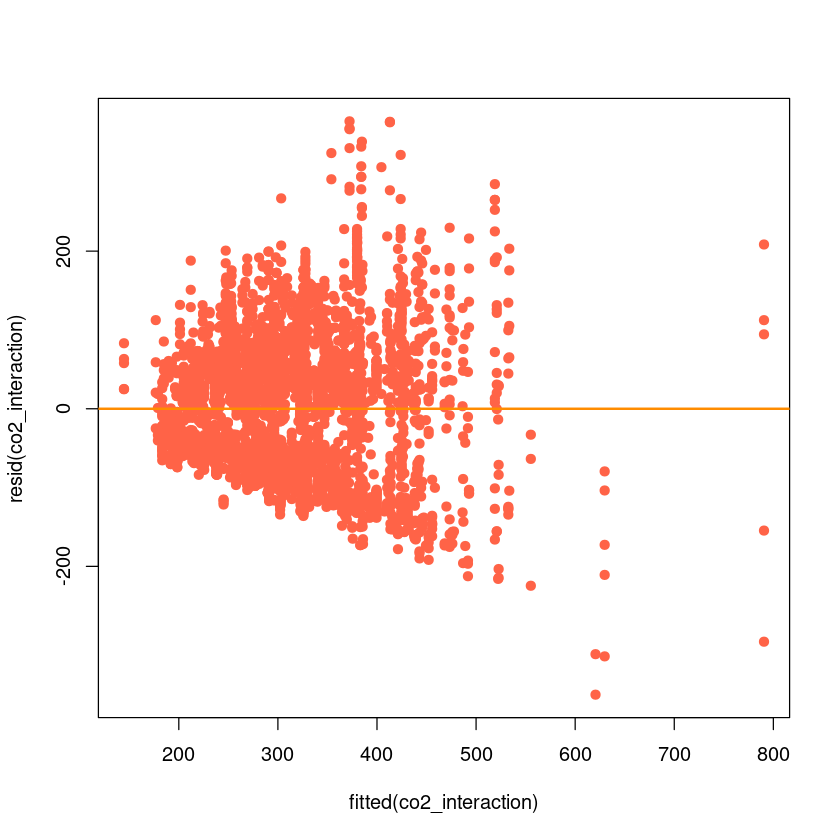


Call:
lm(formula = log(CO2) ~ horse * type + I(horse^2), data = epa2015)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.75526 -0.24592  0.05063  0.21558  0.70559 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      5.068e+00  4.789e-02 105.826   <2e-16 ***
horse            2.703e-03  1.995e-04  13.551   <2e-16 ***
typeCar         -1.014e-01  4.923e-02  -2.059   0.0395 *  
typeTruck        9.345e-02  5.529e-02   1.690   0.0910 .  
I(horse^2)      -1.426e-06  1.286e-07 -11.096   <2e-16 ***
horse:typeCar    7.335e-05  1.957e-04   0.375   0.7078    
horse:typeTruck  9.626e-05  2.141e-04   0.450   0.6530    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2649 on 4404 degrees of freedom
Multiple R-squared:  0.4367,	Adjusted R-squared:  0.436 
F-statistic: 569.1 on 6 and 4404 DF,  p-value: < 2.2e-16


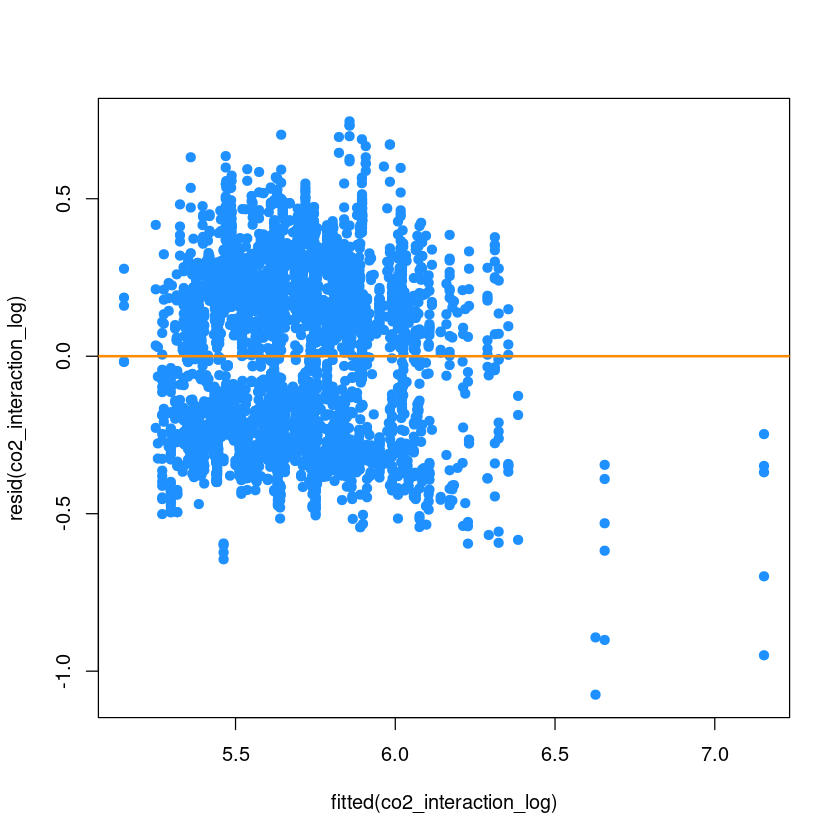

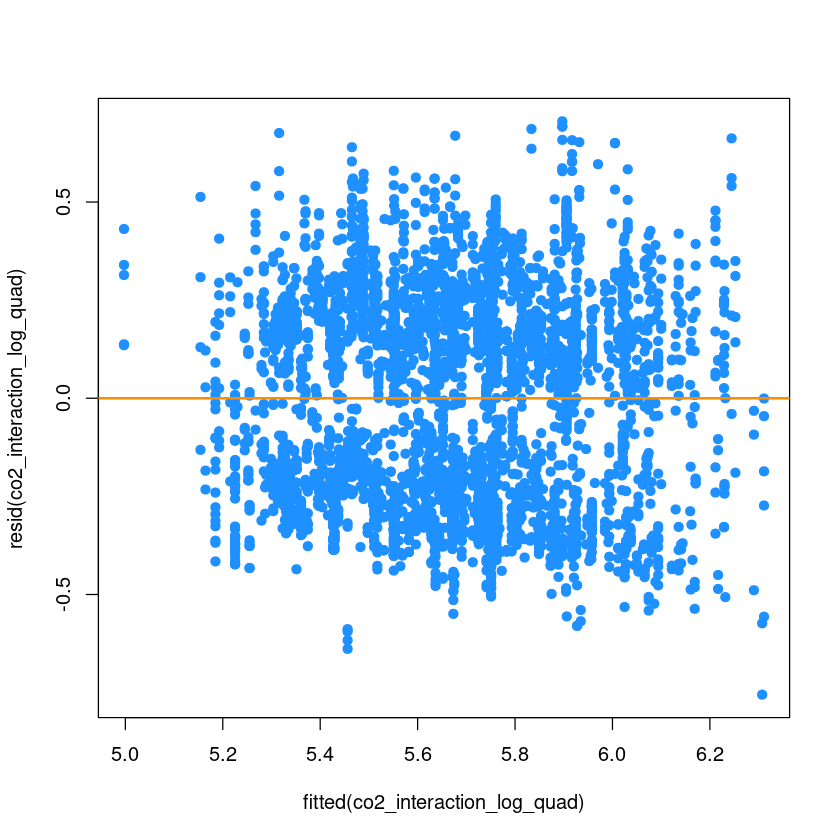

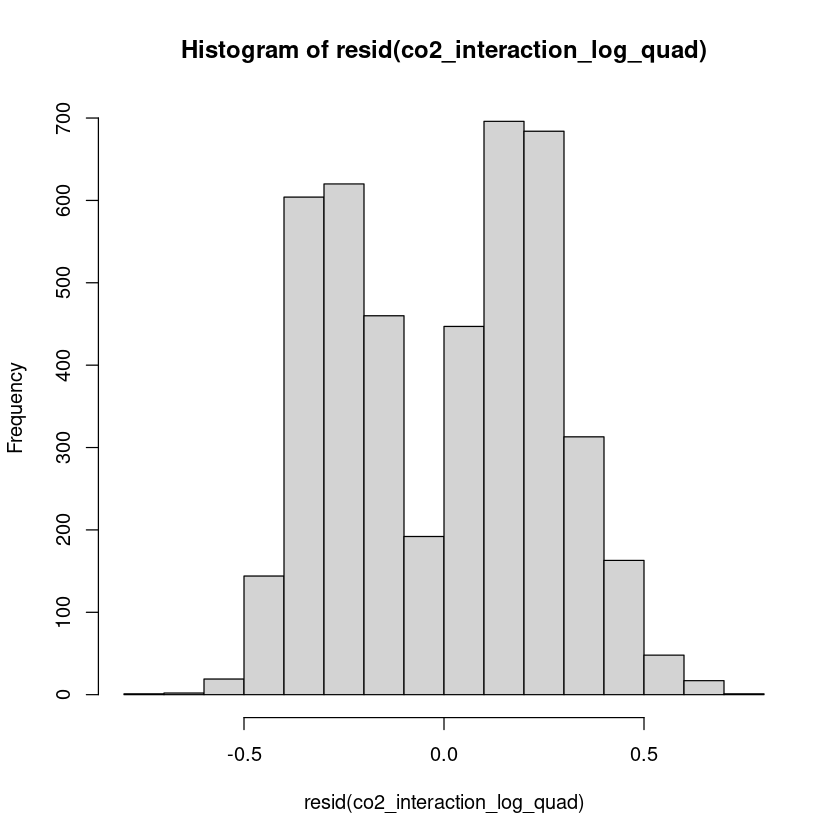

[1] 0.049

[1] 0.007

[1] 0.152

[1] 0.047

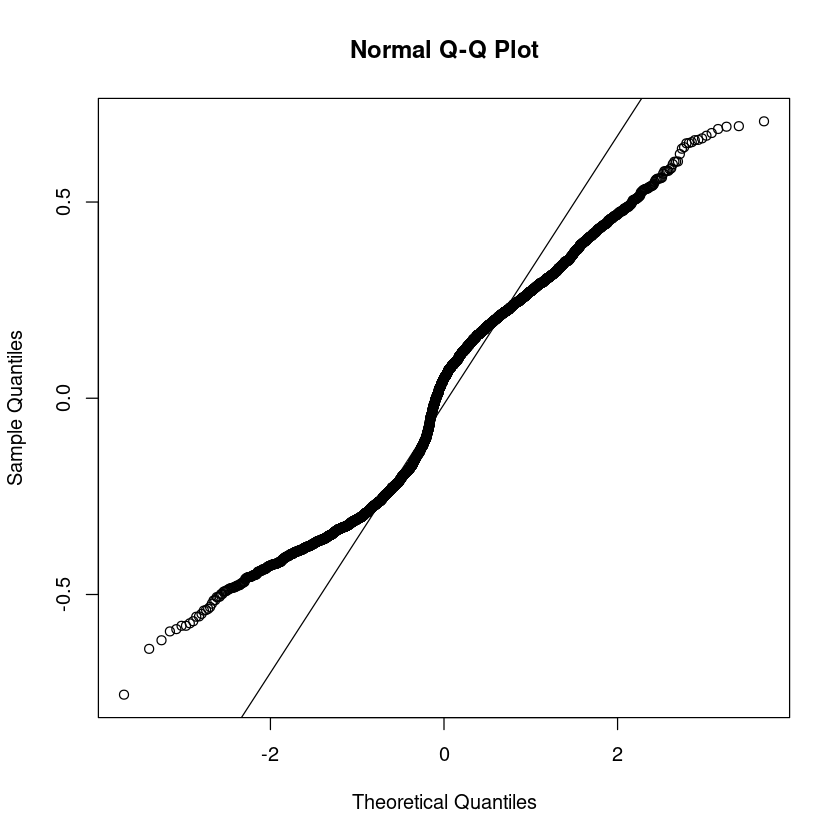

In [3]:
epa2015 <- read_csv("https://raw.githubusercontent.com/alokkshukla/STAT420/master/HW8/epa2015.csv")

# detail description of 4411 vehibles manufactured in 2015
# used for fuel economy testing
epa2015 %>% glimpse()

co2_interaction <- lm(CO2 ~ horse * type, data = epa2015)
summary(co2_interaction)

# check for equal variance assumption
plot(fitted(co2_interaction), resid(co2_interaction), pch = 20, cex = 1.5, col = "tomato")
abline(h = 0, col = "darkorange", lwd = 2)

lmtest::bptest(co2_interaction)
# fitted versus residuals looks bad, the variance increases for larger fitted values
# and BP test p.value < 0.05 so reject H0
# we concludes that the equal variance assumption is violated


# fit model with log response
co2_interaction_log <- lm(log(CO2) ~ horse * type, data = epa2015)
summary(co2_interaction_log)

plot(fitted(co2_interaction_log), resid(co2_interaction_log),
  pch = 20, cex = 1.5,
  col = "dodgerblue"
)
abline(h = 0, lwd = 2, col = "darkorange")


# we have cleared up the non-constant variance a bit
# but we have another problem, the linear assumption is violated
# there seems to be a quadratic trend here

co2_interaction_log_quad <- lm(log(CO2) ~ horse * type + I(horse ^ 2), data = epa2015)
summary(co2_interaction_log_quad)

# checking for linear and equal variance assumption
# fitted versus residual plot looks good
plot(fitted(co2_interaction_log_quad), resid(co2_interaction_log_quad),
  pch = 20, cex = 1.5,
  col = "dodgerblue"
)
abline(h = 0, lwd = 2, col = "darkorange")

# checking for normality assumption
hist(resid(co2_interaction_log_quad), breaks = 20)

qqnorm(resid(co2_interaction_log_quad))
qqline(resid(co2_interaction_log_quad))

# conclusion: The normality assumption is violated



sample_size <- 50
set.seed(1)
x1 <- runif(sample_size, 0, 10)
x2 <- runif(sample_size, -5, 5)
beta0 <- 2
beta1 <- 1
beta2 <- 0
nsims <- 1000

# epsilon ~ N(0, 1)
sim_beta2 <- function(variance) {
  y1 <- beta0 + beta1 * x1 + beta2 * x2 + rnorm(sample_size, mean = 0, sd = variance)
  fit1 <- lm(y1 ~ x1 + x2)
	summary(fit1)$coefficients[3, 4]
}

# H0: beta2 = 0
# H1: beta2 != 0
# in this simulation beta2 = 0  (H0 is true)
beta_hat_pvalue_equal_var <- rerun(nsims, sim_beta2(1))
# constant variance, expect 5% of time we reject H0
mean(beta_hat_pvalue_equal_var < 0.05)
# constant variance, expect 1% of time we reject H0
mean(beta_hat_pvalue_equal_var < 0.01)




beta_hat_pvalue_unequal_var <- rerun(nsims, sim_beta2(abs(x2)))
# constant variance, expect 5% of time we reject H0
# turns out, this is not correct for the case
# when the variance of residuals is not constant
# so we cannot make inference, it will be misleading and incorrect
mean(beta_hat_pvalue_unequal_var < 0.05)
mean(beta_hat_pvalue_unequal_var < 0.01)